## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [2]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [3]:
df_train = pd.read_csv("../../data/train/protein/protein_maccs_train.csv")
df_test = pd.read_csv("../../data/train/protein/protein_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/protein/protein_maccs_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'protein_plasma_binding']
y_train_all = df_train_all['protein_plasma_binding']

X_train = df_train.loc[:, df_train.columns != 'protein_plasma_binding']
y_train = df_train['protein_plasma_binding']

X_test = df_test.loc[:, df_test.columns != 'protein_plasma_binding']
y_test = df_test['protein_plasma_binding']

X_valid = df_valid.loc[:, df_valid.columns != 'protein_plasma_binding']
y_valid = df_valid['protein_plasma_binding']

In [5]:
X_train.shape

(1864, 166)

In [6]:
X_test.shape

(533, 166)

In [7]:
X_valid.shape

(266, 166)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [8]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(166, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [10]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [11]:
best_value = 1000
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=266, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 2652.9204380875926, Accuracy: -5.997238074931116
Test Avg. loss: 2224.33935546875, Accuracy: -2.733596013609937
################## EPOCH 2 ##################
Train Avg. loss: 960.7888256008342, Accuracy: -1.6725427864852076
Test Avg. loss: 1605.1973876953125, Accuracy: -1.6943545062652237
################## EPOCH 3 ##################
Train Avg. loss: 887.6057640980866, Accuracy: -1.4213565425837382
Test Avg. loss: 1288.1910400390625, Accuracy: -1.1622533537328241
################## EPOCH 4 ##################
Train Avg. loss: 955.2716540320445, Accuracy: -1.664681298234244
Test Avg. loss: 1363.1319580078125, Accuracy: -1.2880430486128822
################## EPOCH 5 ##################
Train Avg. loss: 952.2435318251787, Accuracy: -1.7019784152369786
Test Avg. loss: 1182.1708984375, Accuracy: -0.9842964502650842
################## EPOCH 6 ##################
Train Avg. loss: 891.8558515128443, Accu

Train Avg. loss: 572.9686455160885, Accuracy: -0.7262918386975037
Test Avg. loss: 350.06256103515625, Accuracy: 0.4124132539510811
################## EPOCH 48 ##################
Train Avg. loss: 630.3958070399398, Accuracy: -0.927491261307417
Test Avg. loss: 418.7142639160156, Accuracy: 0.2971800965012594
################## EPOCH 49 ##################
Train Avg. loss: 597.6685915154926, Accuracy: -0.8902692015017047
Test Avg. loss: 339.6617126464844, Accuracy: 0.4298713099226278
################## EPOCH 50 ##################
Train Avg. loss: 619.5119499594479, Accuracy: -0.8842665333668507
Test Avg. loss: 314.80059814453125, Accuracy: 0.47160118846739196
################## EPOCH 51 ##################
Train Avg. loss: 597.5922055001986, Accuracy: -0.8502486577188699
Test Avg. loss: 325.37445068359375, Accuracy: 0.4538527750373136
################## EPOCH 52 ##################
Train Avg. loss: 588.1591486526748, Accuracy: -0.9203270009931054
Test Avg. loss: 291.6756896972656, Accuracy: 0

Train Avg. loss: 496.73907496565477, Accuracy: -0.5666998155209795
Test Avg. loss: 317.8632507324219, Accuracy: 0.46646044665455944
################## EPOCH 95 ##################
Train Avg. loss: 519.4849090576172, Accuracy: -0.6415061709001809
Test Avg. loss: 300.25244140625, Accuracy: 0.49602050759370675
################## EPOCH 96 ##################
Train Avg. loss: 526.4191268662275, Accuracy: -0.77517853260784
Test Avg. loss: 284.6789245605469, Accuracy: 0.5221610103514689
################## EPOCH 97 ##################
Train Avg. loss: 481.30298110186044, Accuracy: -0.5062509693434039
Test Avg. loss: 258.93206787109375, Accuracy: 0.5653775747883556
################## EPOCH 98 ##################
Train Avg. loss: 509.89276485119836, Accuracy: -0.6268493784563961
Test Avg. loss: 359.8279724121094, Accuracy: 0.39602182591395907
################## EPOCH 99 ##################
Train Avg. loss: 499.2263567649712, Accuracy: -0.6621360130121499
Test Avg. loss: 304.7318115234375, Accuracy: 0

Train Avg. loss: 464.9890483274298, Accuracy: -0.5364101562750012
Test Avg. loss: 279.8227844238281, Accuracy: 0.5303121002219022
################## EPOCH 141 ##################
Train Avg. loss: 474.0017451916711, Accuracy: -0.4160456011732167
Test Avg. loss: 244.31446838378906, Accuracy: 0.5899134828793254
################## EPOCH 142 ##################
Train Avg. loss: 454.4409779694121, Accuracy: -0.477237119298051
Test Avg. loss: 298.2853088378906, Accuracy: 0.4993223705038007
################## EPOCH 143 ##################
Train Avg. loss: 452.3539141638804, Accuracy: -0.43243649445828775
Test Avg. loss: 277.46435546875, Accuracy: 0.5342707891904779
################## EPOCH 144 ##################
Train Avg. loss: 463.7715707552635, Accuracy: -0.5580218721413102
Test Avg. loss: 273.8020324707031, Accuracy: 0.5404180709928781
################## EPOCH 145 ##################
Train Avg. loss: 475.18800276416846, Accuracy: -0.4684229092179296
Test Avg. loss: 288.7806701660156, Accuracy:

Train Avg. loss: 396.919365058511, Accuracy: -0.3041264391149767
Test Avg. loss: 251.4904327392578, Accuracy: 0.5778684684488113
################## EPOCH 187 ##################
Train Avg. loss: 421.65372945494573, Accuracy: -0.35423844945387434
Test Avg. loss: 258.2825927734375, Accuracy: 0.5664676939065137
################## EPOCH 188 ##################
Train Avg. loss: 436.86531403105135, Accuracy: -0.4242508719745357
Test Avg. loss: 240.0189971923828, Accuracy: 0.5971235268294277
################## EPOCH 189 ##################
Train Avg. loss: 431.66893807104077, Accuracy: -0.4566897767979758
Test Avg. loss: 240.2366485595703, Accuracy: 0.5967581911454802
################## EPOCH 190 ##################
Train Avg. loss: 407.6071973897643, Accuracy: -0.5171904914534357
Test Avg. loss: 256.9162902832031, Accuracy: 0.5687610627274202
################## EPOCH 191 ##################
Train Avg. loss: 402.18557222010725, Accuracy: -0.18590141631036372
Test Avg. loss: 291.1283264160156, Accu

Train Avg. loss: 400.81909386586335, Accuracy: -0.2713211297842997
Test Avg. loss: 268.5778503417969, Accuracy: 0.5491869553778939
################## EPOCH 233 ##################
Train Avg. loss: 376.98344951564985, Accuracy: -0.25747718280030796
Test Avg. loss: 325.31304931640625, Accuracy: 0.4539558696904218
################## EPOCH 234 ##################
Train Avg. loss: 383.61923864332294, Accuracy: -0.24612834242777887
Test Avg. loss: 243.05783081054688, Accuracy: 0.5920227307007191
################## EPOCH 235 ##################
Train Avg. loss: 382.85025774422337, Accuracy: -0.27835090528460277
Test Avg. loss: 261.4058532714844, Accuracy: 0.5612253260078638
################## EPOCH 236 ##################
Train Avg. loss: 387.3953456555383, Accuracy: -0.25033583295084044
Test Avg. loss: 243.1017303466797, Accuracy: 0.591949116515539
################## EPOCH 237 ##################
Train Avg. loss: 376.99525529247217, Accuracy: -0.2188407465709166
Test Avg. loss: 228.8760528564453,

Train Avg. loss: 380.534736503989, Accuracy: -0.15589745573421412
Test Avg. loss: 246.38645935058594, Accuracy: 0.5864356213750705
################## EPOCH 279 ##################
Train Avg. loss: 347.78247872045483, Accuracy: -0.07480599121954624
Test Avg. loss: 256.8340759277344, Accuracy: 0.5688991354962651
################## EPOCH 280 ##################
Train Avg. loss: 378.05247626870363, Accuracy: -0.19130164884877765
Test Avg. loss: 249.165771484375, Accuracy: 0.5817704935313558
################## EPOCH 281 ##################
Train Avg. loss: 357.92044300144, Accuracy: -0.12508603799757842
Test Avg. loss: 243.21051025390625, Accuracy: 0.5917665082267576
################## EPOCH 282 ##################
Train Avg. loss: 360.9409585726463, Accuracy: -0.12079575843035517
Test Avg. loss: 266.9228210449219, Accuracy: 0.5519649373873268
################## EPOCH 283 ##################
Train Avg. loss: 384.47148778883076, Accuracy: -0.223922522148453
Test Avg. loss: 283.31866455078125, Acc

Train Avg. loss: 689.9856689453125, Accuracy: -0.6196214142937112
Test Avg. loss: 746.875732421875, Accuracy: -0.25364510016998953
################## EPOCH 25 ##################
Train Avg. loss: 666.900727335612, Accuracy: -0.5192186923306976
Test Avg. loss: 587.4937133789062, Accuracy: 0.013880530362170962
################## EPOCH 26 ##################
Train Avg. loss: 655.697090657552, Accuracy: -0.4599174375392367
Test Avg. loss: 647.6090087890625, Accuracy: -0.08702410239644176
################## EPOCH 27 ##################
Train Avg. loss: 650.8302490234375, Accuracy: -0.5314974930998563
Test Avg. loss: 510.1686096191406, Accuracy: 0.14367229317671915
################## EPOCH 28 ##################
Train Avg. loss: 646.9904571533203, Accuracy: -0.48451452872049694
Test Avg. loss: 634.3606567382812, Accuracy: -0.06478648905666606
################## EPOCH 29 ##################
Train Avg. loss: 681.2321940104167, Accuracy: -0.562259328471357
Test Avg. loss: 475.6971435546875, Accuracy

Train Avg. loss: 508.79633280436195, Accuracy: -0.20522282892778204
Test Avg. loss: 425.5956115722656, Accuracy: 0.2856296325991834
################## EPOCH 72 ##################
Train Avg. loss: 533.4329274495443, Accuracy: -0.2895061848319796
Test Avg. loss: 324.8153381347656, Accuracy: 0.4547913026205619
################## EPOCH 73 ##################
Train Avg. loss: 530.896517944336, Accuracy: -0.27792416922439106
Test Avg. loss: 382.3419189453125, Accuracy: 0.3582318059160454
################## EPOCH 74 ##################
Train Avg. loss: 486.9783925374349, Accuracy: -0.15648513983684093
Test Avg. loss: 360.21759033203125, Accuracy: 0.39536786377709043
################## EPOCH 75 ##################
Train Avg. loss: 497.4116912841797, Accuracy: -0.16370931126974228
Test Avg. loss: 320.26934814453125, Accuracy: 0.46242173718310864
################## EPOCH 76 ##################
Train Avg. loss: 495.9030008951823, Accuracy: -0.21965543392507694
Test Avg. loss: 323.6092834472656, Accur

Train Avg. loss: 456.27027994791666, Accuracy: -0.10864280071507014
Test Avg. loss: 318.316162109375, Accuracy: 0.46570021228812275
################## EPOCH 119 ##################
Train Avg. loss: 459.1841145833333, Accuracy: -0.08743579729216384
Test Avg. loss: 285.8177185058594, Accuracy: 0.5202495077849202
################## EPOCH 120 ##################
Train Avg. loss: 471.1451649983724, Accuracy: -0.09121505573978603
Test Avg. loss: 289.7148742675781, Accuracy: 0.5137080679685977
################## EPOCH 121 ##################
Train Avg. loss: 491.13878173828124, Accuracy: -0.11214890814460203
Test Avg. loss: 329.968994140625, Accuracy: 0.44614071491285
################## EPOCH 122 ##################
Train Avg. loss: 481.1510645548503, Accuracy: -0.10737662043139234
Test Avg. loss: 298.97882080078125, Accuracy: 0.49815829224135244
################## EPOCH 123 ##################
Train Avg. loss: 454.5097930908203, Accuracy: -0.09267021951316108
Test Avg. loss: 309.6383972167969, Ac

Train Avg. loss: 435.88646138509114, Accuracy: -0.03742614663307484
Test Avg. loss: 278.3634948730469, Accuracy: 0.5327615856679588
################## EPOCH 165 ##################
Train Avg. loss: 436.61716512044273, Accuracy: -0.021744159464706796
Test Avg. loss: 274.2287902832031, Accuracy: 0.5397017007888123
################## EPOCH 166 ##################
Train Avg. loss: 442.2230204264323, Accuracy: -0.034586900769000874
Test Avg. loss: 264.7677307128906, Accuracy: 0.5555823084326854
################## EPOCH 167 ##################
Train Avg. loss: 424.80185852050784, Accuracy: -0.028269481716271527
Test Avg. loss: 278.3810729980469, Accuracy: 0.5327320182442286
################## EPOCH 168 ##################
Train Avg. loss: 415.6990163167318, Accuracy: -0.0007940627247049063
Test Avg. loss: 284.5634460449219, Accuracy: 0.5223547935042682
################## EPOCH 169 ##################
Train Avg. loss: 425.1434061686198, Accuracy: -0.02605654270656329
Test Avg. loss: 267.4171752929

Train Avg. loss: 417.40435892740885, Accuracy: 0.010259682685969052
Test Avg. loss: 316.3541564941406, Accuracy: 0.4689934707800788
################## EPOCH 211 ##################
Train Avg. loss: 375.62779286702477, Accuracy: 0.10491897591802252
Test Avg. loss: 280.6636047363281, Accuracy: 0.5289007542545059
################## EPOCH 212 ##################
Train Avg. loss: 420.64759063720703, Accuracy: 0.01952738261829718
Test Avg. loss: 301.5334167480469, Accuracy: 0.49387039462941384
################## EPOCH 213 ##################
Train Avg. loss: 423.1987233479818, Accuracy: -0.006665349264966776
Test Avg. loss: 322.3671875, Accuracy: 0.4589005336934914
################## EPOCH 214 ##################
Train Avg. loss: 431.2770141601562, Accuracy: -0.04955037036894636
Test Avg. loss: 294.27899169921875, Accuracy: 0.506047096601298
################## EPOCH 215 ##################
Train Avg. loss: 374.2020721435547, Accuracy: 0.05832264579162708
Test Avg. loss: 300.61138916015625, Accura

Train Avg. loss: 392.6108861287435, Accuracy: 0.062142482586527985
Test Avg. loss: 258.69537353515625, Accuracy: 0.5657748577728154
################## EPOCH 257 ##################
Train Avg. loss: 365.2666900634766, Accuracy: 0.12552119004869797
Test Avg. loss: 288.5308532714844, Accuracy: 0.5156954445335546
################## EPOCH 258 ##################
Train Avg. loss: 377.6638735453288, Accuracy: 0.08913713415574823
Test Avg. loss: 228.8700714111328, Accuracy: 0.6158372005605591
################## EPOCH 259 ##################
Train Avg. loss: 397.11900126139324, Accuracy: 0.021767988446877575
Test Avg. loss: 257.7007141113281, Accuracy: 0.5674444353863918
################## EPOCH 260 ##################
Train Avg. loss: 402.4007059733073, Accuracy: 0.06038740006501428
Test Avg. loss: 273.8214111328125, Accuracy: 0.5403855103315996
################## EPOCH 261 ##################
Train Avg. loss: 379.4751592000326, Accuracy: 0.1401428097647841
Test Avg. loss: 259.5695495605469, Accura

Train Avg. loss: 972.1666381835937, Accuracy: -1.0008814733516183
Test Avg. loss: 2431.904296875, Accuracy: -3.081997352752916
################## EPOCH 4 ##################
Train Avg. loss: 819.8389119466145, Accuracy: -0.6885092726431978
Test Avg. loss: 1836.9920654296875, Accuracy: -2.0834262949978672
################## EPOCH 5 ##################
Train Avg. loss: 823.8817993164063, Accuracy: -0.6898890048316435
Test Avg. loss: 1503.998779296875, Accuracy: -1.524490681029059
################## EPOCH 6 ##################
Train Avg. loss: 775.37705078125, Accuracy: -0.5955606330737135
Test Avg. loss: 1582.9036865234375, Accuracy: -1.6569340096072689
################## EPOCH 7 ##################
Train Avg. loss: 727.797314453125, Accuracy: -0.49430048656541725
Test Avg. loss: 1435.5479736328125, Accuracy: -1.4095948266963347
################## EPOCH 8 ##################
Train Avg. loss: 736.5974731445312, Accuracy: -0.5142380459561381
Test Avg. loss: 1388.6563720703125, Accuracy: -1.3308

Train Avg. loss: 480.3291748046875, Accuracy: 0.005300095760228452
Test Avg. loss: 396.7928466796875, Accuracy: 0.33397562991963436
################## EPOCH 53 ##################
Train Avg. loss: 474.1494384765625, Accuracy: 0.017625882909861706
Test Avg. loss: 422.4417419433594, Accuracy: 0.2909234070452117
################## EPOCH 54 ##################
Train Avg. loss: 494.6964090983073, Accuracy: -0.025886313739710915
Test Avg. loss: 458.0710754394531, Accuracy: 0.2311189393906583
################## EPOCH 55 ##################
Train Avg. loss: 481.64942830403646, Accuracy: -0.007359676666827989
Test Avg. loss: 455.6919250488281, Accuracy: 0.23511248048267852
################## EPOCH 56 ##################
Train Avg. loss: 463.5200520833333, Accuracy: 0.051144448227358634
Test Avg. loss: 338.48651123046875, Accuracy: 0.4318439142504338
################## EPOCH 57 ##################
Train Avg. loss: 453.0112650553385, Accuracy: 0.05838973158753161
Test Avg. loss: 480.11279296875, Accur

Train Avg. loss: 419.76487019856773, Accuracy: 0.1254794690842436
Test Avg. loss: 306.8380432128906, Accuracy: 0.4849664948344994
################## EPOCH 101 ##################
Train Avg. loss: 421.4834228515625, Accuracy: 0.11474028792736739
Test Avg. loss: 266.30224609375, Accuracy: 0.5530065482914803
################## EPOCH 102 ##################
Train Avg. loss: 415.2956095377604, Accuracy: 0.13648789814753587
Test Avg. loss: 338.0764465332031, Accuracy: 0.43253219708445145
################## EPOCH 103 ##################
Train Avg. loss: 425.6038289388021, Accuracy: 0.11888597167055555
Test Avg. loss: 324.27960205078125, Accuracy: 0.4556904798714986
################## EPOCH 104 ##################
Train Avg. loss: 402.03212076822916, Accuracy: 0.165857006546792
Test Avg. loss: 307.409423828125, Accuracy: 0.48400735638239956
################## EPOCH 105 ##################
Train Avg. loss: 422.9511433919271, Accuracy: 0.10615382356199698
Test Avg. loss: 298.3525085449219, Accuracy: 

Train Avg. loss: 393.2391764322917, Accuracy: 0.16512877848701002
Test Avg. loss: 278.3791809082031, Accuracy: 0.5327352063151385
################## EPOCH 148 ##################
Train Avg. loss: 399.9580383300781, Accuracy: 0.16271788207902718
Test Avg. loss: 272.4730529785156, Accuracy: 0.5426487942319334
################## EPOCH 149 ##################
Train Avg. loss: 367.6069763183594, Accuracy: 0.23181184766095939
Test Avg. loss: 288.714111328125, Accuracy: 0.5153878338421152
################## EPOCH 150 ##################
Train Avg. loss: 384.4304545084635, Accuracy: 0.1962200583049036
Test Avg. loss: 303.4006652832031, Accuracy: 0.49073616128198094
################## EPOCH 151 ##################
Train Avg. loss: 379.7505350748698, Accuracy: 0.20246513085494194
Test Avg. loss: 320.9125061035156, Accuracy: 0.46134218957091655
################## EPOCH 152 ##################
Train Avg. loss: 386.449062093099, Accuracy: 0.20330600223350762
Test Avg. loss: 292.8638000488281, Accuracy: 

Train Avg. loss: 376.8911112467448, Accuracy: 0.20729094169251253
Test Avg. loss: 281.28631591796875, Accuracy: 0.5278555252154562
################## EPOCH 196 ##################
Train Avg. loss: 382.9047037760417, Accuracy: 0.20201375761763574
Test Avg. loss: 259.4632873535156, Accuracy: 0.5644859273518282
################## EPOCH 197 ##################
Train Avg. loss: 376.4060831705729, Accuracy: 0.2116152196476265
Test Avg. loss: 269.7125244140625, Accuracy: 0.5472823729639456
################## EPOCH 198 ##################
Train Avg. loss: 357.0392720540365, Accuracy: 0.25684405481305267
Test Avg. loss: 290.233642578125, Accuracy: 0.5128372822311733
################## EPOCH 199 ##################
Train Avg. loss: 366.1474304199219, Accuracy: 0.2378211809574669
Test Avg. loss: 305.15777587890625, Accuracy: 0.4877867930175036
################## EPOCH 200 ##################
Train Avg. loss: 384.2019470214844, Accuracy: 0.2018510140019414
Test Avg. loss: 358.3639221191406, Accuracy: 0

Train Avg. loss: 352.1975362141927, Accuracy: 0.2593916680395689
Test Avg. loss: 267.67266845703125, Accuracy: 0.5507062674427057
################## EPOCH 244 ##################
Train Avg. loss: 336.83103434244794, Accuracy: 0.29426456002668533
Test Avg. loss: 290.2628173828125, Accuracy: 0.5127883362422463
################## EPOCH 245 ##################
Train Avg. loss: 345.3307596842448, Accuracy: 0.28212043901966394
Test Avg. loss: 274.47174072265625, Accuracy: 0.539293932904495
################## EPOCH 246 ##################
Train Avg. loss: 363.53327026367185, Accuracy: 0.24144475339809066
Test Avg. loss: 276.1371765136719, Accuracy: 0.536498475961858
################## EPOCH 247 ##################
Train Avg. loss: 334.3943603515625, Accuracy: 0.29291836326705883
Test Avg. loss: 307.3949890136719, Accuracy: 0.48403161054746513
################## EPOCH 248 ##################
Train Avg. loss: 353.51001790364586, Accuracy: 0.2642126546092165
Test Avg. loss: 309.9869079589844, Accurac

Train Avg. loss: 354.1699279785156, Accuracy: 0.27097872847968585
Test Avg. loss: 267.8740539550781, Accuracy: 0.550368298304674
################## EPOCH 292 ##################
Train Avg. loss: 347.509853108724, Accuracy: 0.28018691460850703
Test Avg. loss: 264.5054931640625, Accuracy: 0.5560224743370112
################## EPOCH 293 ##################
Train Avg. loss: 339.2815856933594, Accuracy: 0.29127787288162815
Test Avg. loss: 249.17152404785156, Accuracy: 0.5817607934506974
################## EPOCH 294 ##################
Train Avg. loss: 345.2994425455729, Accuracy: 0.2772070511555919
Test Avg. loss: 266.3404235839844, Accuracy: 0.5529425094604714
################## EPOCH 295 ##################
Train Avg. loss: 340.84747314453125, Accuracy: 0.289206139670539
Test Avg. loss: 285.32830810546875, Accuracy: 0.5210709518705819
################## EPOCH 296 ##################
Train Avg. loss: 346.08079427083334, Accuracy: 0.2739839225850445
Test Avg. loss: 269.8315124511719, Accuracy: 0

Train Avg. loss: 617.3830490112305, Accuracy: -0.24576842544548375
Test Avg. loss: 781.662353515625, Accuracy: -0.3120352152218564
################## EPOCH 40 ##################
Train Avg. loss: 601.577522277832, Accuracy: -0.22724605871543319
Test Avg. loss: 814.3114624023438, Accuracy: -0.36683731365231087
################## EPOCH 41 ##################
Train Avg. loss: 585.2174530029297, Accuracy: -0.19310200387068868
Test Avg. loss: 872.21728515625, Accuracy: -0.4640334640088619
################## EPOCH 42 ##################
Train Avg. loss: 602.2954521179199, Accuracy: -0.21875780027865172
Test Avg. loss: 780.1709594726562, Accuracy: -0.3095318869509047
################## EPOCH 43 ##################
Train Avg. loss: 606.4617385864258, Accuracy: -0.23213709105009775
Test Avg. loss: 682.2485961914062, Accuracy: -0.14516741104300723
################## EPOCH 44 ##################
Train Avg. loss: 612.4606475830078, Accuracy: -0.25236568274535265
Test Avg. loss: 730.4818725585938, Accur

Train Avg. loss: 512.1843490600586, Accuracy: -0.04301375528371852
Test Avg. loss: 449.2294006347656, Accuracy: 0.24595987900362937
################## EPOCH 87 ##################
Train Avg. loss: 483.3514404296875, Accuracy: 0.010441251519339848
Test Avg. loss: 430.80279541015625, Accuracy: 0.27688932494041196
################## EPOCH 88 ##################
Train Avg. loss: 491.9915351867676, Accuracy: -0.004085439597887028
Test Avg. loss: 443.5625915527344, Accuracy: 0.25547173114152966
################## EPOCH 89 ##################
Train Avg. loss: 502.5196838378906, Accuracy: -0.023700453357013526
Test Avg. loss: 422.4398498535156, Accuracy: 0.29092658160984886
################## EPOCH 90 ##################
Train Avg. loss: 511.6133728027344, Accuracy: -0.04182710503569144
Test Avg. loss: 481.1790771484375, Accuracy: 0.19233168934803324
################## EPOCH 91 ##################
Train Avg. loss: 527.8819389343262, Accuracy: -0.0809438362842987
Test Avg. loss: 494.4676513671875, A

Train Avg. loss: 453.11098861694336, Accuracy: 0.0701567845773436
Test Avg. loss: 423.675048828125, Accuracy: 0.28885331358525
################## EPOCH 136 ##################
Train Avg. loss: 477.5415916442871, Accuracy: 0.021554489950118536
Test Avg. loss: 396.5577392578125, Accuracy: 0.3343702564191954
################## EPOCH 137 ##################
Train Avg. loss: 470.4377670288086, Accuracy: 0.04169971095437554
Test Avg. loss: 375.3820495605469, Accuracy: 0.3699140192537521
################## EPOCH 138 ##################
Train Avg. loss: 458.1642646789551, Accuracy: 0.05985279230200578
Test Avg. loss: 405.1811218261719, Accuracy: 0.3198957723845628
################## EPOCH 139 ##################
Train Avg. loss: 491.444637298584, Accuracy: -0.003936339489509874
Test Avg. loss: 423.2028503417969, Accuracy: 0.2896459407081686
################## EPOCH 140 ##################
Train Avg. loss: 492.90865325927734, Accuracy: -0.0065928608720656895
Test Avg. loss: 348.1056823730469, Accura

Train Avg. loss: 462.95032119750977, Accuracy: 0.055154099821147246
Test Avg. loss: 362.0804138183594, Accuracy: 0.39224103777869446
################## EPOCH 184 ##################
Train Avg. loss: 439.77151107788086, Accuracy: 0.10442105498370867
Test Avg. loss: 310.9391784667969, Accuracy: 0.47808261433788224
################## EPOCH 185 ##################
Train Avg. loss: 457.2786178588867, Accuracy: 0.06728027007938629
Test Avg. loss: 382.72027587890625, Accuracy: 0.3575967201329918
################## EPOCH 186 ##################
Train Avg. loss: 436.82708740234375, Accuracy: 0.1100757337565878
Test Avg. loss: 324.10174560546875, Accuracy: 0.45598902034775257
################## EPOCH 187 ##################
Train Avg. loss: 439.7761573791504, Accuracy: 0.1050742320895084
Test Avg. loss: 364.7536315917969, Accuracy: 0.38775407224103375
################## EPOCH 188 ##################
Train Avg. loss: 431.1233215332031, Accuracy: 0.1182714684460962
Test Avg. loss: 289.8088684082031, Ac

Train Avg. loss: 418.81317138671875, Accuracy: 0.13983485134504958
Test Avg. loss: 307.4230041503906, Accuracy: 0.4839846387639585
################## EPOCH 230 ##################
Train Avg. loss: 447.6648254394531, Accuracy: 0.08397508952400749
Test Avg. loss: 346.515869140625, Accuracy: 0.41836649636261203
################## EPOCH 231 ##################
Train Avg. loss: 462.74567794799805, Accuracy: 0.053029995480353406
Test Avg. loss: 373.7651062011719, Accuracy: 0.37262812900640696
################## EPOCH 232 ##################
Train Avg. loss: 410.15107345581055, Accuracy: 0.15868258475205746
Test Avg. loss: 320.6005859375, Accuracy: 0.4618657988800463
################## EPOCH 233 ##################
Train Avg. loss: 408.4125518798828, Accuracy: 0.1627097504106996
Test Avg. loss: 295.2481994628906, Accuracy: 0.5044202668277307
################## EPOCH 234 ##################
Train Avg. loss: 407.33927154541016, Accuracy: 0.16691209705881543
Test Avg. loss: 327.0901794433594, Accurac

Train Avg. loss: 408.0756950378418, Accuracy: 0.1653553731021654
Test Avg. loss: 300.3724670410156, Accuracy: 0.49581906251326113
################## EPOCH 278 ##################
Train Avg. loss: 405.3560791015625, Accuracy: 0.17175621367798072
Test Avg. loss: 268.80267333984375, Accuracy: 0.5488095763043452
################## EPOCH 279 ##################
Train Avg. loss: 399.86702728271484, Accuracy: 0.18295571177508163
Test Avg. loss: 346.7845764160156, Accuracy: 0.4179154699030604
################## EPOCH 280 ##################
Train Avg. loss: 411.68027114868164, Accuracy: 0.16113313230743642
Test Avg. loss: 343.58538818359375, Accuracy: 0.4232853746361992
################## EPOCH 281 ##################
Train Avg. loss: 404.48322677612305, Accuracy: 0.17451397802725194
Test Avg. loss: 271.6187438964844, Accuracy: 0.5440827439944399
################## EPOCH 282 ##################
Train Avg. loss: 413.7912139892578, Accuracy: 0.1562026729765148
Test Avg. loss: 327.1039123535156, Accur

Train Avg. loss: 728.8486974683858, Accuracy: -1.2401037183823127
Test Avg. loss: 435.5616149902344, Accuracy: 0.26890151109055205
################## EPOCH 24 ##################
Train Avg. loss: 666.8215275134071, Accuracy: -1.1567383959408153
Test Avg. loss: 357.8066101074219, Accuracy: 0.39941481016845526
################## EPOCH 25 ##################
Train Avg. loss: 660.5599711789923, Accuracy: -0.9513814550998789
Test Avg. loss: 562.7567138671875, Accuracy: 0.05540211652773386
################## EPOCH 26 ##################
Train Avg. loss: 686.4694012140824, Accuracy: -0.9860043555559377
Test Avg. loss: 416.71856689453125, Accuracy: 0.30052993864631594
################## EPOCH 27 ##################
Train Avg. loss: 747.9672396385064, Accuracy: -1.1676666987049165
Test Avg. loss: 354.3468017578125, Accuracy: 0.4052221146451327
################## EPOCH 28 ##################
Train Avg. loss: 658.9324925309521, Accuracy: -1.045000943689676
Test Avg. loss: 356.3807678222656, Accuracy: 

Train Avg. loss: 496.89877474510064, Accuracy: -0.4982479690499448
Test Avg. loss: 271.8294372558594, Accuracy: 0.5437291354471067
################## EPOCH 71 ##################
Train Avg. loss: 496.4624605340473, Accuracy: -0.5499675322077988
Test Avg. loss: 252.4316864013672, Accuracy: 0.5762885687940653
################## EPOCH 72 ##################
Train Avg. loss: 483.6797475006621, Accuracy: -0.46591010382406406
Test Avg. loss: 262.664794921875, Accuracy: 0.559112106792738
################## EPOCH 73 ##################
Train Avg. loss: 483.1893491583355, Accuracy: -0.4964163307104803
Test Avg. loss: 254.471923828125, Accuracy: 0.5728639526629582
################## EPOCH 74 ##################
Train Avg. loss: 526.7622059967558, Accuracy: -0.6907566039393062
Test Avg. loss: 240.09352111816406, Accuracy: 0.5969984631928338
################## EPOCH 75 ##################
Train Avg. loss: 480.21137664277677, Accuracy: -0.4730572153336316
Test Avg. loss: 267.6260681152344, Accuracy: 0.5

Train Avg. loss: 410.4093692585573, Accuracy: -0.2619035837279227
Test Avg. loss: 253.17117309570312, Accuracy: 0.5750473861308796
################## EPOCH 117 ##################
Train Avg. loss: 398.3814376572431, Accuracy: -0.1704416106901023
Test Avg. loss: 264.11297607421875, Accuracy: 0.5566813910356609
################## EPOCH 118 ##################
Train Avg. loss: 385.62848391775356, Accuracy: -0.253248066561954
Test Avg. loss: 275.3452453613281, Accuracy: 0.5378277122743271
################## EPOCH 119 ##################
Train Avg. loss: 418.858791545286, Accuracy: -0.33077020049790956
Test Avg. loss: 274.5663146972656, Accuracy: 0.5391351305598694
################## EPOCH 120 ##################
Train Avg. loss: 380.83778950319453, Accuracy: -0.1778460000641306
Test Avg. loss: 252.7838134765625, Accuracy: 0.5756975295024288
################## EPOCH 121 ##################
Train Avg. loss: 411.06895938162074, Accuracy: -0.3478407286783634
Test Avg. loss: 244.7123565673828, Accur

Train Avg. loss: 323.5961314055879, Accuracy: 0.00429203927816734
Test Avg. loss: 240.78965759277344, Accuracy: 0.5958299609546067
################## EPOCH 163 ##################
Train Avg. loss: 304.9904332565049, Accuracy: 0.10291046412433213
Test Avg. loss: 246.5441131591797, Accuracy: 0.5861709417685352
################## EPOCH 164 ##################
Train Avg. loss: 311.7077318611792, Accuracy: -0.005610982255858455
Test Avg. loss: 266.3134460449219, Accuracy: 0.552987790758083
################## EPOCH 165 ##################
Train Avg. loss: 307.1461445436639, Accuracy: 0.07421056631504908
Test Avg. loss: 247.34507751464844, Accuracy: 0.5848265294050108
################## EPOCH 166 ##################
Train Avg. loss: 332.4363977464579, Accuracy: -0.035989466296772424
Test Avg. loss: 265.2232666015625, Accuracy: 0.5548176538185661
################## EPOCH 167 ##################
Train Avg. loss: 322.96373891022245, Accuracy: -0.013375541832903664
Test Avg. loss: 259.9664611816406, A

Train Avg. loss: 294.4470618296478, Accuracy: 0.1324375248895978
Test Avg. loss: 257.64837646484375, Accuracy: 0.5675322520620396
################## EPOCH 209 ##################
Train Avg. loss: 298.2036616438526, Accuracy: 0.12581379244095403
Test Avg. loss: 277.40625, Accuracy: 0.5343683121754541
################## EPOCH 210 ##################
Train Avg. loss: 299.43037634380795, Accuracy: 0.10518943522071239
Test Avg. loss: 289.1618957519531, Accuracy: 0.5146361876336583
################## EPOCH 211 ##################
Train Avg. loss: 279.4882085767843, Accuracy: 0.14157569507373496
Test Avg. loss: 273.7424011230469, Accuracy: 0.540518142552459
################## EPOCH 212 ##################
Train Avg. loss: 266.8744806839248, Accuracy: 0.20042520353325582
Test Avg. loss: 256.4513244628906, Accuracy: 0.5695416148874054
################## EPOCH 213 ##################
Train Avg. loss: 267.39413594391385, Accuracy: 0.1861396658180866
Test Avg. loss: 238.5399627685547, Accuracy: 0.59960

Train Avg. loss: 250.58518529342393, Accuracy: 0.3202392729892622
Test Avg. loss: 285.52813720703125, Accuracy: 0.5207355426712965
################## EPOCH 256 ##################
Train Avg. loss: 265.463554511636, Accuracy: 0.24159030899354925
Test Avg. loss: 290.2410888671875, Accuracy: 0.5128247790921729
################## EPOCH 257 ##################
Train Avg. loss: 270.17996888241527, Accuracy: 0.23201892552554385
Test Avg. loss: 271.7909851074219, Accuracy: 0.543793643511819
################## EPOCH 258 ##################
Train Avg. loss: 254.52197511317365, Accuracy: 0.20980317429048143
Test Avg. loss: 283.2862854003906, Accuracy: 0.5244985605218487
################## EPOCH 259 ##################
Train Avg. loss: 262.96382916983913, Accuracy: 0.20617327841125066
Test Avg. loss: 298.4905090332031, Accuracy: 0.49897794919141325
################## EPOCH 260 ##################
Train Avg. loss: 295.2978153552039, Accuracy: 0.11269097561712249
Test Avg. loss: 272.3282470703125, Accura

Train Avg. loss: 1199.0581787109375, Accuracy: -1.6180160504385392
Test Avg. loss: 813.8755493164062, Accuracy: -0.3661057227368625
################## EPOCH 3 ##################
Train Avg. loss: 961.3080017089844, Accuracy: -1.1142366237755896
Test Avg. loss: 691.0650634765625, Accuracy: -0.1599658507642383
################## EPOCH 4 ##################
Train Avg. loss: 1075.9501118977864, Accuracy: -1.3924156495865347
Test Avg. loss: 756.662841796875, Accuracy: -0.27007302439239234
################## EPOCH 5 ##################
Train Avg. loss: 979.1563720703125, Accuracy: -1.170753901581331
Test Avg. loss: 607.823974609375, Accuracy: -0.02024414521727591
################## EPOCH 6 ##################
Train Avg. loss: 968.1610493977864, Accuracy: -1.1409688509959677
Test Avg. loss: 591.3640747070312, Accuracy: 0.007384044755350483
################## EPOCH 7 ##################
Train Avg. loss: 883.8165954589844, Accuracy: -0.9787765990017943
Test Avg. loss: 632.6474609375, Accuracy: -0.06

Train Avg. loss: 601.5267456054687, Accuracy: -0.43611813778778863
Test Avg. loss: 331.3980407714844, Accuracy: 0.44374208030864737
################## EPOCH 50 ##################
Train Avg. loss: 531.1267069498698, Accuracy: -0.2253018537500266
Test Avg. loss: 316.95538330078125, Accuracy: 0.4679843185019166
################## EPOCH 51 ##################
Train Avg. loss: 561.6217213948568, Accuracy: -0.27202305688900247
Test Avg. loss: 280.4892883300781, Accuracy: 0.5291933672827303
################## EPOCH 52 ##################
Train Avg. loss: 548.0436706542969, Accuracy: -0.2951540993926231
Test Avg. loss: 390.1270751953125, Accuracy: 0.34516428140434385
################## EPOCH 53 ##################
Train Avg. loss: 557.8950266520183, Accuracy: -0.30747708300882387
Test Avg. loss: 338.58172607421875, Accuracy: 0.4316841521293403
################## EPOCH 54 ##################
Train Avg. loss: 541.0696034749349, Accuracy: -0.273464822370367
Test Avg. loss: 304.1903381347656, Accuracy

Train Avg. loss: 446.0360641479492, Accuracy: -0.0795143327270724
Test Avg. loss: 281.6605529785156, Accuracy: 0.5272273642728684
################## EPOCH 96 ##################
Train Avg. loss: 450.601708984375, Accuracy: -0.06470178785394845
Test Avg. loss: 268.76495361328125, Accuracy: 0.5488728373720133
################## EPOCH 97 ##################
Train Avg. loss: 445.07530415852864, Accuracy: -0.07994525406937268
Test Avg. loss: 297.569091796875, Accuracy: 0.5005246065998733
################## EPOCH 98 ##################
Train Avg. loss: 466.60816345214846, Accuracy: -0.11652928982226674
Test Avg. loss: 319.9904479980469, Accuracy: 0.4628899112645932
################## EPOCH 99 ##################
Train Avg. loss: 433.0428873697917, Accuracy: 0.0014099958777907225
Test Avg. loss: 264.41278076171875, Accuracy: 0.5561780875661047
################## EPOCH 100 ##################
Train Avg. loss: 445.91133677164714, Accuracy: -0.03720044524681668
Test Avg. loss: 260.5476989746094, Accu

Train Avg. loss: 369.31724344889324, Accuracy: 0.11606805848811892
Test Avg. loss: 258.876953125, Accuracy: 0.5654701134322996
################## EPOCH 142 ##################
Train Avg. loss: 398.37197062174477, Accuracy: 0.06832916968403555
Test Avg. loss: 322.60504150390625, Accuracy: 0.45850123100356566
################## EPOCH 143 ##################
Train Avg. loss: 381.007883199056, Accuracy: 0.11261673827568512
Test Avg. loss: 301.09454345703125, Accuracy: 0.4946070278277529
################## EPOCH 144 ##################
Train Avg. loss: 361.1063725789388, Accuracy: 0.16411155241709524
Test Avg. loss: 252.89248657226562, Accuracy: 0.5755151213760964
################## EPOCH 145 ##################
Train Avg. loss: 376.9418390909831, Accuracy: 0.10679432092595813
Test Avg. loss: 271.97509765625, Accuracy: 0.5434845858702476
################## EPOCH 146 ##################
Train Avg. loss: 386.37535502115884, Accuracy: 0.04974951001546334
Test Avg. loss: 249.05938720703125, Accuracy

Train Avg. loss: 359.4646230061849, Accuracy: 0.14931211521645585
Test Avg. loss: 286.33349609375, Accuracy: 0.5193837352997022
################## EPOCH 190 ##################
Train Avg. loss: 353.5814493815104, Accuracy: 0.1437027014607075
Test Avg. loss: 297.3128662109375, Accuracy: 0.5009546488892838
################## EPOCH 191 ##################
Train Avg. loss: 320.5605728149414, Accuracy: 0.25832457737743575
Test Avg. loss: 250.82586669921875, Accuracy: 0.5789839639065113
################## EPOCH 192 ##################
Train Avg. loss: 337.69175618489584, Accuracy: 0.21353600899533579
Test Avg. loss: 273.9612121582031, Accuracy: 0.5401508691103898
################## EPOCH 193 ##################
Train Avg. loss: 329.7747278849284, Accuracy: 0.21322188381753548
Test Avg. loss: 255.18850708007812, Accuracy: 0.5716612343290518
################## EPOCH 194 ##################
Train Avg. loss: 341.15649261474607, Accuracy: 0.22076990972488128
Test Avg. loss: 261.9083251953125, Accuracy

Train Avg. loss: 290.87340850830077, Accuracy: 0.34849056417799446
Test Avg. loss: 304.5396728515625, Accuracy: 0.48882432874350756
################## EPOCH 237 ##################
Train Avg. loss: 319.35165150960285, Accuracy: 0.24718813861607938
Test Avg. loss: 251.4499053955078, Accuracy: 0.5779365029557053
################## EPOCH 238 ##################
Train Avg. loss: 290.44873046875, Accuracy: 0.3019614026983357
Test Avg. loss: 261.5057678222656, Accuracy: 0.5610575701300257
################## EPOCH 239 ##################
Train Avg. loss: 302.22508697509767, Accuracy: 0.2814563052668702
Test Avg. loss: 254.58758544921875, Accuracy: 0.572669846225691
################## EPOCH 240 ##################
Train Avg. loss: 322.82268778483075, Accuracy: 0.23333857537989916
Test Avg. loss: 263.3528747558594, Accuracy: 0.5579572173452645
################## EPOCH 241 ##################
Train Avg. loss: 302.5048472086589, Accuracy: 0.29390535219008473
Test Avg. loss: 292.9021301269531, Accuracy

Train Avg. loss: 305.2707824707031, Accuracy: 0.31419665252426227
Test Avg. loss: 294.48419189453125, Accuracy: 0.5057026639695106
################## EPOCH 284 ##################
Train Avg. loss: 287.76159845987956, Accuracy: 0.3246440686087915
Test Avg. loss: 269.1195983886719, Accuracy: 0.5482776179970317
################## EPOCH 285 ##################
Train Avg. loss: 289.569091796875, Accuracy: 0.33119364653782096
Test Avg. loss: 265.70684814453125, Accuracy: 0.5540059753713591
################## EPOCH 286 ##################
Train Avg. loss: 282.1106918334961, Accuracy: 0.3487433625750624
Test Avg. loss: 246.3140411376953, Accuracy: 0.5865571824715923
################## EPOCH 287 ##################
Train Avg. loss: 266.82427673339845, Accuracy: 0.3526938426563586
Test Avg. loss: 261.0974426269531, Accuracy: 0.5617428952749401
################## EPOCH 288 ##################
Train Avg. loss: 262.81956939697267, Accuracy: 0.3976735053742411
Test Avg. loss: 264.3006896972656, Accuracy:

Train Avg. loss: 729.8612263997396, Accuracy: -0.5101108048078001
Test Avg. loss: 437.0615539550781, Accuracy: 0.2663838183696521
################## EPOCH 31 ##################
Train Avg. loss: 678.4996948242188, Accuracy: -0.4146008643555051
Test Avg. loss: 361.3374938964844, Accuracy: 0.39348810166863835
################## EPOCH 32 ##################
Train Avg. loss: 681.0795003255208, Accuracy: -0.3980364121407894
Test Avg. loss: 489.9922180175781, Accuracy: 0.17753868430270447
################## EPOCH 33 ##################
Train Avg. loss: 723.2991963704427, Accuracy: -0.49574536716219497
Test Avg. loss: 387.5342102050781, Accuracy: 0.34951641886604334
################## EPOCH 34 ##################
Train Avg. loss: 682.8956013997396, Accuracy: -0.40905468093127156
Test Avg. loss: 451.3306884765625, Accuracy: 0.2424327610998268
################## EPOCH 35 ##################
Train Avg. loss: 669.8917643229166, Accuracy: -0.40414322561658217
Test Avg. loss: 366.42022705078125, Accurac

Train Avg. loss: 561.1790832519531, Accuracy: -0.16065541014637258
Test Avg. loss: 286.66339111328125, Accuracy: 0.5188300435390607
################## EPOCH 78 ##################
Train Avg. loss: 540.5349751790365, Accuracy: -0.11984352372841506
Test Avg. loss: 304.9454040527344, Accuracy: 0.4881433263688403
################## EPOCH 79 ##################
Train Avg. loss: 553.1629638671875, Accuracy: -0.1567167667604105
Test Avg. loss: 350.3147277832031, Accuracy: 0.41199003721200433
################## EPOCH 80 ##################
Train Avg. loss: 591.1033426920573, Accuracy: -0.2482603363812774
Test Avg. loss: 322.13165283203125, Accuracy: 0.4592958733111353
################## EPOCH 81 ##################
Train Avg. loss: 531.9648701985677, Accuracy: -0.11617683066652777
Test Avg. loss: 287.7902526855469, Accuracy: 0.5169385868277858
################## EPOCH 82 ##################
Train Avg. loss: 524.8688049316406, Accuracy: -0.09629277053449105
Test Avg. loss: 344.6269836425781, Accurac

Test Avg. loss: 290.97906494140625, Accuracy: 0.5115860490924768
################## EPOCH 125 ##################
Train Avg. loss: 493.48606363932294, Accuracy: -0.04369343449891452
Test Avg. loss: 286.5060119628906, Accuracy: 0.5190941577697232
################## EPOCH 126 ##################
Train Avg. loss: 467.4983805338542, Accuracy: 0.018406634032708806
Test Avg. loss: 314.8511657714844, Accuracy: 0.47151629603827083
################## EPOCH 127 ##################
Train Avg. loss: 476.600244140625, Accuracy: 0.0028940153040555453
Test Avg. loss: 298.3349914550781, Accuracy: 0.49923897239662784
################## EPOCH 128 ##################
Train Avg. loss: 484.47193806966146, Accuracy: -0.006857441269705844
Test Avg. loss: 263.1069641113281, Accuracy: 0.5583698893895593
################## EPOCH 129 ##################
Train Avg. loss: 473.0152323404948, Accuracy: -0.007069538214829474
Test Avg. loss: 354.6683654785156, Accuracy: 0.40468239363009884
################## EPOCH 130 ####

Train Avg. loss: 455.06993611653644, Accuracy: 0.039930975310145306
Test Avg. loss: 258.45184326171875, Accuracy: 0.5661836224493565
################## EPOCH 174 ##################
Train Avg. loss: 437.3355000813802, Accuracy: 0.08239459741797157
Test Avg. loss: 300.7015075683594, Accuracy: 0.4952667486707354
################## EPOCH 175 ##################
Train Avg. loss: 462.52305501302084, Accuracy: 0.03020957297733991
Test Avg. loss: 231.5717315673828, Accuracy: 0.6113024013935928
################## EPOCH 176 ##################
Train Avg. loss: 474.6158040364583, Accuracy: 0.006696408981028871
Test Avg. loss: 324.3654479980469, Accuracy: 0.4555463710814378
################## EPOCH 177 ##################
Train Avg. loss: 440.7050435384115, Accuracy: 0.08472410547964355
Test Avg. loss: 270.507568359375, Accuracy: 0.5459478891929495
################## EPOCH 178 ##################
Train Avg. loss: 423.5605733235677, Accuracy: 0.11434491541643384
Test Avg. loss: 327.72772216796875, Accu

Train Avg. loss: 425.296435546875, Accuracy: 0.1084039151944139
Test Avg. loss: 322.8561096191406, Accuracy: 0.4580798453793272
################## EPOCH 222 ##################
Train Avg. loss: 388.31618041992186, Accuracy: 0.18675155822953352
Test Avg. loss: 291.6014709472656, Accuracy: 0.5105413198158144
################## EPOCH 223 ##################
Train Avg. loss: 395.56113688151044, Accuracy: 0.17408040677699874
Test Avg. loss: 271.0971374511719, Accuracy: 0.5449582829677587
################## EPOCH 224 ##################
Train Avg. loss: 410.5861755371094, Accuracy: 0.14111617530737605
Test Avg. loss: 374.7048645019531, Accuracy: 0.37105070767337245
################## EPOCH 225 ##################
Train Avg. loss: 448.2252237955729, Accuracy: 0.06089530072941251
Test Avg. loss: 252.2437286376953, Accuracy: 0.5766040878108694
################## EPOCH 226 ##################
Train Avg. loss: 443.30718587239585, Accuracy: 0.06293664890204799
Test Avg. loss: 265.6647644042969, Accurac

Train Avg. loss: 433.94593302408856, Accuracy: 0.08889835299980058
Test Avg. loss: 378.5123291015625, Accuracy: 0.3646598360058514
################## EPOCH 268 ##################
Train Avg. loss: 407.2252726236979, Accuracy: 0.1621562009249951
Test Avg. loss: 255.51971435546875, Accuracy: 0.5711052736600957
################## EPOCH 269 ##################
Train Avg. loss: 392.08702596028644, Accuracy: 0.1774883696543841
Test Avg. loss: 325.2881164550781, Accuracy: 0.45399766358363314
################## EPOCH 270 ##################
Train Avg. loss: 372.9976847330729, Accuracy: 0.21528947637462328
Test Avg. loss: 258.3059387207031, Accuracy: 0.5664285589784904
################## EPOCH 271 ##################
Train Avg. loss: 388.21522420247396, Accuracy: 0.19273313195915523
Test Avg. loss: 290.2613525390625, Accuracy: 0.5127908002739079
################## EPOCH 272 ##################
Train Avg. loss: 407.0442850748698, Accuracy: 0.1598388715876223
Test Avg. loss: 305.81561279296875, Accura

Train Avg. loss: 841.3596801757812, Accuracy: -0.6995893528797572
Test Avg. loss: 509.945556640625, Accuracy: 0.14404660539290115
################## EPOCH 16 ##################
Train Avg. loss: 819.6745681762695, Accuracy: -0.6593274554549495
Test Avg. loss: 687.983642578125, Accuracy: -0.15479365186869232
################## EPOCH 17 ##################
Train Avg. loss: 858.645133972168, Accuracy: -0.7607848137456629
Test Avg. loss: 632.396728515625, Accuracy: -0.06149003962340571
################## EPOCH 18 ##################
Train Avg. loss: 808.8656005859375, Accuracy: -0.649244467926041
Test Avg. loss: 518.0892944335938, Accuracy: 0.13037716516861841
################## EPOCH 19 ##################
Train Avg. loss: 808.6007690429688, Accuracy: -0.6486211051117612
Test Avg. loss: 647.3012084960938, Accuracy: -0.08650753637915254
################## EPOCH 20 ##################
Train Avg. loss: 823.7294311523438, Accuracy: -0.6751068111599119
Test Avg. loss: 480.7897033691406, Accuracy: 0

Train Avg. loss: 593.0691184997559, Accuracy: -0.20668009838843626
Test Avg. loss: 439.9030456542969, Accuracy: 0.26161434373744374
################## EPOCH 66 ##################
Train Avg. loss: 600.9852676391602, Accuracy: -0.22649215834604763
Test Avg. loss: 450.48138427734375, Accuracy: 0.24385839939308152
################## EPOCH 67 ##################
Train Avg. loss: 600.4671859741211, Accuracy: -0.2212519265922721
Test Avg. loss: 485.6047668457031, Accuracy: 0.18490314641119754
################## EPOCH 68 ##################
Train Avg. loss: 563.0578765869141, Accuracy: -0.1412604625036297
Test Avg. loss: 381.56536865234375, Accuracy: 0.35953523314840763
################## EPOCH 69 ##################
Train Avg. loss: 596.203125, Accuracy: -0.21071450079306436
Test Avg. loss: 360.6057434082031, Accuracy: 0.39471639781174395
################## EPOCH 70 ##################
Train Avg. loss: 625.4942207336426, Accuracy: -0.2668158040987909
Test Avg. loss: 375.9459228515625, Accuracy: 0

Train Avg. loss: 543.1679077148438, Accuracy: -0.10827302309796541
Test Avg. loss: 359.8485107421875, Accuracy: 0.39598740131618315
################## EPOCH 114 ##################
Train Avg. loss: 547.3034362792969, Accuracy: -0.12050824150848514
Test Avg. loss: 476.417724609375, Accuracy: 0.20032375972280514
################## EPOCH 115 ##################
Train Avg. loss: 526.9951438903809, Accuracy: -0.07996354770654893
Test Avg. loss: 434.69732666015625, Accuracy: 0.27035222879653076
################## EPOCH 116 ##################
Train Avg. loss: 570.8387603759766, Accuracy: -0.17567962361938838
Test Avg. loss: 386.4138488769531, Accuracy: 0.3513969734604324
################## EPOCH 117 ##################
Train Avg. loss: 520.4767646789551, Accuracy: -0.0592987582037138
Test Avg. loss: 465.4179382324219, Accuracy: 0.21878706179641205
################## EPOCH 118 ##################
Train Avg. loss: 540.1000671386719, Accuracy: -0.11227637458039104
Test Avg. loss: 436.61865234375, Ac

Train Avg. loss: 504.6647834777832, Accuracy: -0.03784652644556599
Test Avg. loss: 295.666015625, Accuracy: 0.5037189638127477
################## EPOCH 162 ##################
Train Avg. loss: 490.2381401062012, Accuracy: -0.00991195292055777
Test Avg. loss: 288.6999816894531, Accuracy: 0.5154115471585861
################## EPOCH 163 ##################
Train Avg. loss: 535.9147148132324, Accuracy: -0.09554785367941855
Test Avg. loss: 302.31585693359375, Accuracy: 0.4925570495900041
################## EPOCH 164 ##################
Train Avg. loss: 478.7515296936035, Accuracy: 0.02862388648687582
Test Avg. loss: 331.6435241699219, Accuracy: 0.44333002306125424
################## EPOCH 165 ##################
Train Avg. loss: 502.3229789733887, Accuracy: -0.027086850023945633
Test Avg. loss: 450.8635559082031, Accuracy: 0.2432169023964813
################## EPOCH 166 ##################
Train Avg. loss: 458.7222900390625, Accuracy: 0.06765596054641576
Test Avg. loss: 526.5471801757812, Accura

Train Avg. loss: 419.2800483703613, Accuracy: 0.14258397002151935
Test Avg. loss: 377.20965576171875, Accuracy: 0.3668463777325838
################## EPOCH 210 ##################
Train Avg. loss: 436.2512969970703, Accuracy: 0.10988572634297507
Test Avg. loss: 359.8070983886719, Accuracy: 0.3960569087720669
################## EPOCH 211 ##################
Train Avg. loss: 459.0440139770508, Accuracy: 0.05973440784595169
Test Avg. loss: 322.4559020996094, Accuracy: 0.45875158248861025
################## EPOCH 212 ##################
Train Avg. loss: 462.88253021240234, Accuracy: 0.06005642296677714
Test Avg. loss: 372.7576599121094, Accuracy: 0.3743191184672361
################## EPOCH 213 ##################
Train Avg. loss: 464.1128959655762, Accuracy: 0.04797008061975
Test Avg. loss: 340.0789794921875, Accuracy: 0.42917087128627474
################## EPOCH 214 ##################
Train Avg. loss: 478.85620880126953, Accuracy: 0.008414685953722578
Test Avg. loss: 319.0561218261719, Accura

Train Avg. loss: 440.55795669555664, Accuracy: 0.1063708716800756
Test Avg. loss: 330.3013916015625, Accuracy: 0.4455828046318716
################## EPOCH 256 ##################
Train Avg. loss: 446.244441986084, Accuracy: 0.08969118933689159
Test Avg. loss: 376.3348388671875, Accuracy: 0.3683148017379714
################## EPOCH 257 ##################
Train Avg. loss: 431.28649520874023, Accuracy: 0.12384321835918022
Test Avg. loss: 304.5933837890625, Accuracy: 0.48873419304159427
################## EPOCH 258 ##################
Train Avg. loss: 464.1724395751953, Accuracy: 0.05340892151753225
Test Avg. loss: 292.63568115234375, Accuracy: 0.5088054309001554
################## EPOCH 259 ##################
Train Avg. loss: 454.46630859375, Accuracy: 0.06565031692069341
Test Avg. loss: 316.7255554199219, Accuracy: 0.4683700844719847
################## EPOCH 260 ##################
Train Avg. loss: 449.7482452392578, Accuracy: 0.08007908497151836
Test Avg. loss: 351.0928649902344, Accuracy:

Train Avg. loss: 1799.0753856594279, Accuracy: -4.504546971077331
Test Avg. loss: 741.1935424804688, Accuracy: -0.24410755755896973
################## EPOCH 2 ##################
Train Avg. loss: 1170.055841995498, Accuracy: -2.316321357775339
Test Avg. loss: 632.9320678710938, Accuracy: -0.062388541834448086
################## EPOCH 3 ##################
Train Avg. loss: 1153.6537041098384, Accuracy: -2.525283651690703
Test Avg. loss: 645.1152954101562, Accuracy: -0.08283831136584374
################## EPOCH 4 ##################
Train Avg. loss: 981.390713966499, Accuracy: -1.8563329000674085
Test Avg. loss: 624.2149047851562, Accuracy: -0.04775671396879466
################## EPOCH 5 ##################
Train Avg. loss: 1018.9015854657706, Accuracy: -1.9424420263384736
Test Avg. loss: 584.9533081054688, Accuracy: 0.01814465272808452
################## EPOCH 6 ##################
Train Avg. loss: 1056.9975637662208, Accuracy: -1.8623983794033738
Test Avg. loss: 783.2667236328125, Accuracy:

Train Avg. loss: 492.71605359093616, Accuracy: -0.5561297284172697
Test Avg. loss: 252.56671142578125, Accuracy: 0.576061929915741
################## EPOCH 49 ##################
Train Avg. loss: 494.5804883019399, Accuracy: -0.6368565898310468
Test Avg. loss: 301.5724792480469, Accuracy: 0.4938048656031543
################## EPOCH 50 ##################
Train Avg. loss: 476.7497429281978, Accuracy: -0.46978951238678174
Test Avg. loss: 250.57725524902344, Accuracy: 0.579401301115904
################## EPOCH 51 ##################
Train Avg. loss: 515.3330657441737, Accuracy: -0.5664459344535488
Test Avg. loss: 257.7648620605469, Accuracy: 0.5673367433426353
################## EPOCH 52 ##################
Train Avg. loss: 486.22029863777806, Accuracy: -0.5442870278360809
Test Avg. loss: 268.55401611328125, Accuracy: 0.5492269571832828
################## EPOCH 53 ##################
Train Avg. loss: 459.161978511487, Accuracy: -0.6332396092701271
Test Avg. loss: 249.59783935546875, Accuracy: 

Train Avg. loss: 382.567778765145, Accuracy: -0.12903223351504828
Test Avg. loss: 285.6187744140625, Accuracy: 0.5205834317356826
################## EPOCH 96 ##################
Train Avg. loss: 384.65145201602223, Accuracy: -0.15905372751748426
Test Avg. loss: 261.874267578125, Accuracy: 0.5604390328499484
################## EPOCH 97 ##################
Train Avg. loss: 362.3986056053032, Accuracy: -0.11136027027765943
Test Avg. loss: 264.50347900390625, Accuracy: 0.5560258117232886
################## EPOCH 98 ##################
Train Avg. loss: 367.63270180912343, Accuracy: -0.0667241848233312
Test Avg. loss: 248.13328552246094, Accuracy: 0.5835035303094432
################## EPOCH 99 ##################
Train Avg. loss: 385.19624638961534, Accuracy: -0.16350962865691157
Test Avg. loss: 262.1919860839844, Accuracy: 0.5599057322682847
################## EPOCH 100 ##################
Train Avg. loss: 369.6882246631687, Accuracy: -0.1525738897295518
Test Avg. loss: 285.4839172363281, Accura

Train Avg. loss: 326.94935297561904, Accuracy: 0.024410177613399846
Test Avg. loss: 289.4574279785156, Accuracy: 0.5141401828956271
################## EPOCH 142 ##################
Train Avg. loss: 314.94930538888707, Accuracy: 0.07651145190982066
Test Avg. loss: 259.6455078125, Accuracy: 0.5641800433178431
################## EPOCH 143 ##################
Train Avg. loss: 305.37563155869304, Accuracy: 0.10635043345656407
Test Avg. loss: 270.2730712890625, Accuracy: 0.5463414937667617
################## EPOCH 144 ##################
Train Avg. loss: 303.48354093907244, Accuracy: 0.12950092438421432
Test Avg. loss: 268.3340148925781, Accuracy: 0.5495962495161688
################## EPOCH 145 ##################
Train Avg. loss: 298.334413172835, Accuracy: 0.12156894239533222
Test Avg. loss: 258.0765380859375, Accuracy: 0.5668135673838526
################## EPOCH 146 ##################
Train Avg. loss: 311.87830701924986, Accuracy: 0.07231625554470421
Test Avg. loss: 285.4189147949219, Accurac

Train Avg. loss: 314.89726903883076, Accuracy: 0.14618062557846975
Test Avg. loss: 293.2021484375, Accuracy: 0.5078546121825169
################## EPOCH 188 ##################
Train Avg. loss: 297.8548255532475, Accuracy: 0.12255383310454139
Test Avg. loss: 296.2519226074219, Accuracy: 0.5027354736859593
################## EPOCH 189 ##################
Train Avg. loss: 268.6607153941009, Accuracy: 0.2565988954603373
Test Avg. loss: 272.39404296875, Accuracy: 0.5427814017939703
################## EPOCH 190 ##################
Train Avg. loss: 302.6210384045617, Accuracy: 0.09809523489374238
Test Avg. loss: 301.92095947265625, Accuracy: 0.49321988090944635
################## EPOCH 191 ##################
Train Avg. loss: 298.84347922115, Accuracy: 0.16358060441080596
Test Avg. loss: 292.572021484375, Accuracy: 0.5089122945583389
################## EPOCH 192 ##################
Train Avg. loss: 299.3453276036149, Accuracy: 0.11579501053211859
Test Avg. loss: 279.6671447753906, Accuracy: 0.530

Train Avg. loss: 293.4003435555151, Accuracy: 0.2170611961178938
Test Avg. loss: 298.8085021972656, Accuracy: 0.4984442215526862
################## EPOCH 234 ##################
Train Avg. loss: 269.23432366322663, Accuracy: 0.2737237233152065
Test Avg. loss: 313.7572021484375, Accuracy: 0.4733525537079105
################## EPOCH 235 ##################
Train Avg. loss: 289.8196806826834, Accuracy: 0.17653405572443578
Test Avg. loss: 298.6551818847656, Accuracy: 0.49870158972950707
################## EPOCH 236 ##################
Train Avg. loss: 309.1724428079896, Accuracy: 0.1283056105365943
Test Avg. loss: 311.00762939453125, Accuracy: 0.4779677041084329
################## EPOCH 237 ##################
Train Avg. loss: 293.8486423815711, Accuracy: 0.20619147467594645
Test Avg. loss: 282.6852111816406, Accuracy: 0.5255074269478708
################## EPOCH 238 ##################
Train Avg. loss: 321.82751257944915, Accuracy: 0.011037606363538443
Test Avg. loss: 301.91796875, Accuracy: 0.

Train Avg. loss: 267.87926172806044, Accuracy: 0.3230877682240637
Test Avg. loss: 307.88067626953125, Accuracy: 0.483216404126639
################## EPOCH 281 ##################
Train Avg. loss: 264.61379578153964, Accuracy: 0.2937087303333316
Test Avg. loss: 289.18060302734375, Accuracy: 0.5146048111637413
################## EPOCH 282 ##################
Train Avg. loss: 285.2828004481429, Accuracy: 0.2808523710610153
Test Avg. loss: 313.8526611328125, Accuracy: 0.47319232293916536
################## EPOCH 283 ##################
Train Avg. loss: 291.7424326751192, Accuracy: 0.18727776189108464
Test Avg. loss: 296.5699768066406, Accuracy: 0.5022016573830586
################## EPOCH 284 ##################
Train Avg. loss: 287.22657452599475, Accuracy: 0.18708871857699674
Test Avg. loss: 291.9682312011719, Accuracy: 0.5099257427778157
################## EPOCH 285 ##################
Train Avg. loss: 289.6899230439784, Accuracy: 0.24604510976167074
Test Avg. loss: 279.10040283203125, Accura

Train Avg. loss: 729.7578694661458, Accuracy: -0.6678865469839799
Test Avg. loss: 310.7847900390625, Accuracy: 0.4783418361287216
################## EPOCH 28 ##################
Train Avg. loss: 703.3840576171875, Accuracy: -0.6302341975314278
Test Avg. loss: 280.4316101074219, Accuracy: 0.5292902050678661
################## EPOCH 29 ##################
Train Avg. loss: 770.8362645467122, Accuracy: -0.7814114336627019
Test Avg. loss: 413.0903625488281, Accuracy: 0.306619897027552
################## EPOCH 30 ##################
Train Avg. loss: 698.9868245442708, Accuracy: -0.6428786688990885
Test Avg. loss: 551.8712768554688, Accuracy: 0.07367361683158802
################## EPOCH 31 ##################
Train Avg. loss: 748.5069580078125, Accuracy: -0.8186922632666818
Test Avg. loss: 276.9593505859375, Accuracy: 0.5351184519830722
################## EPOCH 32 ##################
Train Avg. loss: 680.7653350830078, Accuracy: -0.5722577905924381
Test Avg. loss: 325.9475402832031, Accuracy: 0.45

Train Avg. loss: 506.7948267618815, Accuracy: -0.21813871553961608
Test Avg. loss: 256.3699645996094, Accuracy: 0.5696780825547043
################## EPOCH 75 ##################
Train Avg. loss: 476.1621846516927, Accuracy: -0.13105488157441827
Test Avg. loss: 236.9655303955078, Accuracy: 0.6022488391231478
################## EPOCH 76 ##################
Train Avg. loss: 498.0687672932943, Accuracy: -0.20572098871922834
Test Avg. loss: 263.3678894042969, Accuracy: 0.5579319348821818
################## EPOCH 77 ##################
Train Avg. loss: 465.64748229980466, Accuracy: -0.07148633388249823
Test Avg. loss: 231.85018920898438, Accuracy: 0.6108350335636279
################## EPOCH 78 ##################
Train Avg. loss: 467.0670440673828, Accuracy: -0.1026141547383332
Test Avg. loss: 229.3989715576172, Accuracy: 0.614949462425216
################## EPOCH 79 ##################
Train Avg. loss: 464.90990753173827, Accuracy: -0.10883220031347747
Test Avg. loss: 223.74729919433594, Accura

Train Avg. loss: 392.73252360026044, Accuracy: 0.09806110056197982
Test Avg. loss: 273.47344970703125, Accuracy: 0.5409695652663105
################## EPOCH 122 ##################
Train Avg. loss: 385.9001057942708, Accuracy: 0.12463959770885609
Test Avg. loss: 264.56085205078125, Accuracy: 0.5559295559896461
################## EPOCH 123 ##################
Train Avg. loss: 385.9615712483724, Accuracy: 0.09132809313425658
Test Avg. loss: 284.5821838378906, Accuracy: 0.5223233488946369
################## EPOCH 124 ##################
Train Avg. loss: 380.45861358642577, Accuracy: 0.1116224447470467
Test Avg. loss: 263.77569580078125, Accuracy: 0.5572474419021882
################## EPOCH 125 ##################
Train Avg. loss: 391.9717046101888, Accuracy: 0.07075997300074603
Test Avg. loss: 274.73486328125, Accuracy: 0.5388522734108337
################## EPOCH 126 ##################
Train Avg. loss: 436.6468744913737, Accuracy: -0.03482695555590092
Test Avg. loss: 272.2296142578125, Accura

Train Avg. loss: 359.23949381510414, Accuracy: 0.164276077582074
Test Avg. loss: 237.11532592773438, Accuracy: 0.6019973671732357
################## EPOCH 168 ##################
Train Avg. loss: 359.83270874023435, Accuracy: 0.1840504593377406
Test Avg. loss: 229.40194702148438, Accuracy: 0.6149444375831179
################## EPOCH 169 ##################
Train Avg. loss: 336.6026006062826, Accuracy: 0.22762330369767925
Test Avg. loss: 236.4725799560547, Accuracy: 0.6030762600500601
################## EPOCH 170 ##################
Train Avg. loss: 346.47825215657554, Accuracy: 0.20985793488972898
Test Avg. loss: 225.2315216064453, Accuracy: 0.6219445875234663
################## EPOCH 171 ##################
Train Avg. loss: 356.42259572347007, Accuracy: 0.17604793827872395
Test Avg. loss: 263.7276916503906, Accuracy: 0.5573280477859185
################## EPOCH 172 ##################
Train Avg. loss: 346.0926564534505, Accuracy: 0.1929193052935515
Test Avg. loss: 249.3801727294922, Accurac

Train Avg. loss: 288.4569356282552, Accuracy: 0.32907589748488253
Test Avg. loss: 265.8538513183594, Accuracy: 0.5537591686030329
################## EPOCH 216 ##################
Train Avg. loss: 296.28236083984376, Accuracy: 0.32530077691480586
Test Avg. loss: 278.2457275390625, Accuracy: 0.5329592695804396
################## EPOCH 217 ##################
Train Avg. loss: 304.6695083618164, Accuracy: 0.3122549363040559
Test Avg. loss: 297.977783203125, Accuracy: 0.4998386013541182
################## EPOCH 218 ##################
Train Avg. loss: 296.9130315144857, Accuracy: 0.32463446005296664
Test Avg. loss: 328.2334899902344, Accuracy: 0.44905382289374096
################## EPOCH 219 ##################
Train Avg. loss: 298.2724619547526, Accuracy: 0.3085203414314101
Test Avg. loss: 302.5866394042969, Accuracy: 0.49210251842151875
################## EPOCH 220 ##################
Train Avg. loss: 314.60298207600914, Accuracy: 0.2929001765405531
Test Avg. loss: 279.2861328125, Accuracy: 0.

Train Avg. loss: 265.8909016927083, Accuracy: 0.4117362832990162
Test Avg. loss: 265.68017578125, Accuracy: 0.5540507530101633
################## EPOCH 263 ##################
Train Avg. loss: 266.35921173095704, Accuracy: 0.3959657410531116
Test Avg. loss: 272.8030700683594, Accuracy: 0.5420948374015772
################## EPOCH 264 ##################
Train Avg. loss: 267.39300333658855, Accuracy: 0.3953946480309382
Test Avg. loss: 264.22412109375, Accuracy: 0.556494750544384
################## EPOCH 265 ##################
Train Avg. loss: 271.4550033569336, Accuracy: 0.3600022069904586
Test Avg. loss: 270.1124267578125, Accuracy: 0.5466111153503582
################## EPOCH 266 ##################
Train Avg. loss: 303.9981979370117, Accuracy: 0.2914653482634049
Test Avg. loss: 298.1763000488281, Accuracy: 0.4995054255269933
################## EPOCH 267 ##################
Train Avg. loss: 318.1936289469401, Accuracy: 0.29653695822499604
Test Avg. loss: 244.10232543945312, Accuracy: 0.5902

Train Avg. loss: 827.0643636067708, Accuracy: -0.6990121482685787
Test Avg. loss: 602.141845703125, Accuracy: -0.01070668710670919
################## EPOCH 11 ##################
Train Avg. loss: 824.9897216796875, Accuracy: -0.6997297272152864
Test Avg. loss: 518.4046630859375, Accuracy: 0.129847872704984
################## EPOCH 12 ##################
Train Avg. loss: 806.1461954752605, Accuracy: -0.6628310730907866
Test Avg. loss: 537.4172973632812, Accuracy: 0.09793480273570143
################## EPOCH 13 ##################
Train Avg. loss: 822.6409342447917, Accuracy: -0.7139286530199095
Test Avg. loss: 577.5357055664062, Accuracy: 0.030595303825606934
################## EPOCH 14 ##################
Train Avg. loss: 776.0723551432292, Accuracy: -0.6026406353693656
Test Avg. loss: 481.2397155761719, Accuracy: 0.19222992785203963
################## EPOCH 15 ##################
Train Avg. loss: 769.3788777669271, Accuracy: -0.5936714569829327
Test Avg. loss: 600.4817504882812, Accuracy: 

Train Avg. loss: 527.2726928710938, Accuracy: -0.08873995309119813
Test Avg. loss: 369.0962829589844, Accuracy: 0.3804648643343943
################## EPOCH 59 ##################
Train Avg. loss: 544.606679280599, Accuracy: -0.11801153798164292
Test Avg. loss: 423.2286682128906, Accuracy: 0.2896026120608062
################## EPOCH 60 ##################
Train Avg. loss: 513.2737813313802, Accuracy: -0.05971467176177413
Test Avg. loss: 364.44866943359375, Accuracy: 0.3882659370696889
################## EPOCH 61 ##################
Train Avg. loss: 525.2108439127604, Accuracy: -0.10076834993725531
Test Avg. loss: 278.7135314941406, Accuracy: 0.5321740437772047
################## EPOCH 62 ##################
Train Avg. loss: 525.875565592448, Accuracy: -0.07937101276126893
Test Avg. loss: 300.6790771484375, Accuracy: 0.4953044084215368
################## EPOCH 63 ##################
Train Avg. loss: 507.9486022949219, Accuracy: -0.05560114120663665
Test Avg. loss: 320.36279296875, Accuracy: 0

Train Avg. loss: 447.2854858398438, Accuracy: 0.07834957478489
Test Avg. loss: 310.0248107910156, Accuracy: 0.4796174180917603
################## EPOCH 107 ##################
Train Avg. loss: 421.2591552734375, Accuracy: 0.12066307822827324
Test Avg. loss: 294.15509033203125, Accuracy: 0.5062550654252711
################## EPOCH 108 ##################
Train Avg. loss: 409.2716979980469, Accuracy: 0.1461699355441302
Test Avg. loss: 374.9988708496094, Accuracy: 0.3705572571658712
################## EPOCH 109 ##################
Train Avg. loss: 434.2750996907552, Accuracy: 0.09347905474650453
Test Avg. loss: 264.9791564941406, Accuracy: 0.5552274140459421
################## EPOCH 110 ##################
Train Avg. loss: 431.4549194335938, Accuracy: 0.09676658469058831
Test Avg. loss: 248.47817993164062, Accuracy: 0.5829246110187687
################## EPOCH 111 ##################
Train Avg. loss: 409.28126220703126, Accuracy: 0.15113777039284534
Test Avg. loss: 315.5013427734375, Accuracy: 

Train Avg. loss: 369.6381591796875, Accuracy: 0.23941384337374488
Test Avg. loss: 338.664306640625, Accuracy: 0.43154544425385577
################## EPOCH 154 ##################
Train Avg. loss: 363.8551513671875, Accuracy: 0.24541607364490245
Test Avg. loss: 273.2049865722656, Accuracy: 0.541420222049067
################## EPOCH 155 ##################
Train Avg. loss: 367.9262186686198, Accuracy: 0.23630582271763215
Test Avg. loss: 278.385498046875, Accuracy: 0.532724619448723
################## EPOCH 156 ##################
Train Avg. loss: 349.7308410644531, Accuracy: 0.2768538329179239
Test Avg. loss: 320.1918640136719, Accuracy: 0.4625518611279411
################## EPOCH 157 ##################
Train Avg. loss: 367.083935546875, Accuracy: 0.2382624354367947
Test Avg. loss: 240.461669921875, Accuracy: 0.5963805045188627
################## EPOCH 158 ##################
Train Avg. loss: 345.791298421224, Accuracy: 0.2772059577656244
Test Avg. loss: 242.4981231689453, Accuracy: 0.592962

Train Avg. loss: 322.3285196940104, Accuracy: 0.33093597127155405
Test Avg. loss: 276.97222900390625, Accuracy: 0.5350968504109057
################## EPOCH 203 ##################
Train Avg. loss: 321.0353312174479, Accuracy: 0.3273275732203811
Test Avg. loss: 266.24212646484375, Accuracy: 0.5531074670481699
################## EPOCH 204 ##################
Train Avg. loss: 320.4046244303385, Accuracy: 0.33095805602959427
Test Avg. loss: 253.23585510253906, Accuracy: 0.5749387847063313
################## EPOCH 205 ##################
Train Avg. loss: 314.5133046468099, Accuracy: 0.3419298817839299
Test Avg. loss: 282.8689880371094, Accuracy: 0.5251990029248556
################## EPOCH 206 ##################
Train Avg. loss: 323.69118245442706, Accuracy: 0.32598657507350487
Test Avg. loss: 254.92774963378906, Accuracy: 0.5720988640645959
################## EPOCH 207 ##################
Train Avg. loss: 323.4102254231771, Accuracy: 0.33132696611908463
Test Avg. loss: 299.1589660644531, Accura

Test Avg. loss: 305.9892578125, Accuracy: 0.48639114646228687
################## EPOCH 250 ##################
Train Avg. loss: 308.1751261393229, Accuracy: 0.3560183165402471
Test Avg. loss: 304.6587219238281, Accuracy: 0.48862448216083243
################## EPOCH 251 ##################
Train Avg. loss: 334.3863759358724, Accuracy: 0.2960144573834967
Test Avg. loss: 278.6923828125, Accuracy: 0.5322094976850298
################## EPOCH 252 ##################
Train Avg. loss: 298.0044759114583, Accuracy: 0.3768050744745623
Test Avg. loss: 340.4220275878906, Accuracy: 0.4285951401418161
################## EPOCH 253 ##################
Train Avg. loss: 300.01283060709636, Accuracy: 0.3783534398135936
Test Avg. loss: 255.1383056640625, Accuracy: 0.5717454535953503
################## EPOCH 254 ##################
Train Avg. loss: 274.0647226969401, Accuracy: 0.43099818570596227
Test Avg. loss: 307.462158203125, Accuracy: 0.4839189148866295
################## EPOCH 255 ##################
Train 

Train Avg. loss: 306.9730234781901, Accuracy: 0.37250458968771777
Test Avg. loss: 320.426513671875, Accuracy: 0.4621579469887207
################## EPOCH 297 ##################
Train Avg. loss: 329.5754669189453, Accuracy: 0.30909831751501693
Test Avg. loss: 329.4729919433594, Accuracy: 0.44697329901503613
################## EPOCH 298 ##################
Train Avg. loss: 307.89972127278645, Accuracy: 0.36698987060982946
Test Avg. loss: 297.977294921875, Accuracy: 0.4998394001924612
################## EPOCH 299 ##################
Train Avg. loss: 294.86904093424477, Accuracy: 0.3779691266261802
Test Avg. loss: 299.722412109375, Accuracy: 0.49691019303298267
################## EPOCH 300 ##################
Train Avg. loss: 296.95473429361977, Accuracy: 0.39703816403155473
Test Avg. loss: 280.17327880859375, Accuracy: 0.5297237461155224
Model: lr 0.01, batch_size 256
################## EPOCH 1 ##################
Train Avg. loss: 3495.209518432617, Accuracy: -6.258019423021935
Test Avg. loss

Train Avg. loss: 593.5215911865234, Accuracy: -0.19544869508250545
Test Avg. loss: 337.247314453125, Accuracy: 0.4339239825411402
################## EPOCH 46 ##################
Train Avg. loss: 568.5767593383789, Accuracy: -0.15517885900415837
Test Avg. loss: 429.40399169921875, Accuracy: 0.2792371566408961
################## EPOCH 47 ##################
Train Avg. loss: 560.5572624206543, Accuracy: -0.13786366423719776
Test Avg. loss: 344.02679443359375, Accuracy: 0.4225444546337317
################## EPOCH 48 ##################
Train Avg. loss: 598.8994674682617, Accuracy: -0.2139935196087379
Test Avg. loss: 303.0887145996094, Accuracy: 0.49125982493206055
################## EPOCH 49 ##################
Train Avg. loss: 577.2582244873047, Accuracy: -0.1554921883706435
Test Avg. loss: 357.980224609375, Accuracy: 0.3991234112200661
################## EPOCH 50 ##################
Train Avg. loss: 520.6188774108887, Accuracy: -0.05490706693539418
Test Avg. loss: 401.9158020019531, Accuracy:

Train Avg. loss: 510.59443283081055, Accuracy: -0.04665556081747005
Test Avg. loss: 302.08380126953125, Accuracy: 0.4929465778375972
################## EPOCH 94 ##################
Train Avg. loss: 458.2354431152344, Accuracy: 0.0714908633074107
Test Avg. loss: 296.1234130859375, Accuracy: 0.5029511905553038
################## EPOCH 95 ##################
Train Avg. loss: 558.5482063293457, Accuracy: -0.1673197666945938
Test Avg. loss: 451.8243408203125, Accuracy: 0.2416042259908333
################## EPOCH 96 ##################
Train Avg. loss: 581.7610893249512, Accuracy: -0.1910212083944175
Test Avg. loss: 397.61566162109375, Accuracy: 0.3325944494055203
################## EPOCH 97 ##################
Train Avg. loss: 545.919319152832, Accuracy: -0.10751955023512363
Test Avg. loss: 289.9815673828125, Accuracy: 0.5132603736578414
################## EPOCH 98 ##################
Train Avg. loss: 536.6748657226562, Accuracy: -0.08741121581102736
Test Avg. loss: 393.47442626953125, Accuracy:

Train Avg. loss: 419.4961357116699, Accuracy: 0.13569044618924306
Test Avg. loss: 271.5357360839844, Accuracy: 0.5442220366643405
################## EPOCH 142 ##################
Train Avg. loss: 400.5762252807617, Accuracy: 0.1827089187526194
Test Avg. loss: 276.1123352050781, Accuracy: 0.5365401350969428
################## EPOCH 143 ##################
Train Avg. loss: 399.17809677124023, Accuracy: 0.19205139862714407
Test Avg. loss: 285.3930358886719, Accuracy: 0.5209623195320825
################## EPOCH 144 ##################
Train Avg. loss: 419.86154556274414, Accuracy: 0.14679770013743176
Test Avg. loss: 281.5761413574219, Accuracy: 0.5273690954076845
################## EPOCH 145 ##################
Train Avg. loss: 395.10279846191406, Accuracy: 0.19754540108559548
Test Avg. loss: 247.9355926513672, Accuracy: 0.5838353516136454
################## EPOCH 146 ##################
Train Avg. loss: 439.01125717163086, Accuracy: 0.10487087753902284
Test Avg. loss: 244.8706817626953, Accura

Train Avg. loss: 383.0563163757324, Accuracy: 0.21574596394021295
Test Avg. loss: 236.35557556152344, Accuracy: 0.6032726677673867
################## EPOCH 189 ##################
Train Avg. loss: 388.338134765625, Accuracy: 0.20765539624373117
Test Avg. loss: 228.56283569335938, Accuracy: 0.6163529416688359
################## EPOCH 190 ##################
Train Avg. loss: 419.0901870727539, Accuracy: 0.14687566819477071
Test Avg. loss: 235.14718627929688, Accuracy: 0.6053009516893558
################## EPOCH 191 ##################
Train Avg. loss: 371.6361885070801, Accuracy: 0.23709775496259744
Test Avg. loss: 234.2628631591797, Accuracy: 0.6067853176611735
################## EPOCH 192 ##################
Train Avg. loss: 393.4726333618164, Accuracy: 0.1929635406592404
Test Avg. loss: 244.04478454589844, Accuracy: 0.5903661536334306
################## EPOCH 193 ##################
Train Avg. loss: 415.88501358032227, Accuracy: 0.1499043303238548
Test Avg. loss: 248.1822509765625, Accurac

Train Avg. loss: 378.3013801574707, Accuracy: 0.22834900014004572
Test Avg. loss: 255.16876220703125, Accuracy: 0.5716942949731019
################## EPOCH 238 ##################
Train Avg. loss: 368.22406005859375, Accuracy: 0.24910444048956593
Test Avg. loss: 276.1741027832031, Accuracy: 0.5364364522056736
################## EPOCH 239 ##################
Train Avg. loss: 352.0863494873047, Accuracy: 0.29211071386785586
Test Avg. loss: 255.7152862548828, Accuracy: 0.5707769746549567
################## EPOCH 240 ##################
Train Avg. loss: 334.5105323791504, Accuracy: 0.3236553537394702
Test Avg. loss: 233.99484252929688, Accuracy: 0.607235181169515
################## EPOCH 241 ##################
Train Avg. loss: 368.7318649291992, Accuracy: 0.24715233219706928
Test Avg. loss: 286.22540283203125, Accuracy: 0.5195651807807153
################## EPOCH 242 ##################
Train Avg. loss: 346.48754501342773, Accuracy: 0.2930496798711688
Test Avg. loss: 261.8605041503906, Accurac

Train Avg. loss: 327.05504035949707, Accuracy: 0.33617764958373664
Test Avg. loss: 260.2178649902344, Accuracy: 0.5632193303489053
################## EPOCH 288 ##################
Train Avg. loss: 336.70377922058105, Accuracy: 0.3129379730491949
Test Avg. loss: 233.1288299560547, Accuracy: 0.6086887982269895
################## EPOCH 289 ##################
Train Avg. loss: 319.482852935791, Accuracy: 0.3506953706876773
Test Avg. loss: 232.47633361816406, Accuracy: 0.6097840214846006
################## EPOCH 290 ##################
Train Avg. loss: 333.00297927856445, Accuracy: 0.3236352961479347
Test Avg. loss: 239.57583618164062, Accuracy: 0.5978673479523828
################## EPOCH 291 ##################
Train Avg. loss: 312.2624759674072, Accuracy: 0.3629829568070313
Test Avg. loss: 253.34364318847656, Accuracy: 0.574757846665779
################## EPOCH 292 ##################
Train Avg. loss: 315.6516761779785, Accuracy: 0.3562203279678718
Test Avg. loss: 257.44091796875, Accuracy: 0.

Train Avg. loss: 561.8314933130297, Accuracy: -0.5915625307272127
Test Avg. loss: 384.7390441894531, Accuracy: 0.35420812874742935
################## EPOCH 35 ##################
Train Avg. loss: 560.5870945817334, Accuracy: -0.5830724960818532
Test Avg. loss: 368.68182373046875, Accuracy: 0.3811605110310792
################## EPOCH 36 ##################
Train Avg. loss: 564.8970859333621, Accuracy: -0.6083065902218725
Test Avg. loss: 375.9150390625, Accuracy: 0.3690194125140359
################## EPOCH 37 ##################
Train Avg. loss: 573.4097559007548, Accuracy: -0.5994806220258044
Test Avg. loss: 398.8031005859375, Accuracy: 0.33060136959000697
################## EPOCH 38 ##################
Train Avg. loss: 562.4776616500595, Accuracy: -0.673089904189133
Test Avg. loss: 430.0331726074219, Accuracy: 0.27818111998814943
################## EPOCH 39 ##################
Train Avg. loss: 588.9422679836467, Accuracy: -0.6068711012627994
Test Avg. loss: 403.1101989746094, Accuracy: 0.32

Train Avg. loss: 475.6450148760262, Accuracy: -0.15617325067540772
Test Avg. loss: 462.6697692871094, Accuracy: 0.22339995469316276
################## EPOCH 81 ##################
Train Avg. loss: 461.2574411165916, Accuracy: -0.07042568169849922
Test Avg. loss: 447.7167053222656, Accuracy: 0.2484990065841165
################## EPOCH 82 ##################
Train Avg. loss: 479.71967406192067, Accuracy: -0.11477986639927526
Test Avg. loss: 467.1396179199219, Accuracy: 0.2158972564212659
################## EPOCH 83 ##################
Train Avg. loss: 466.5679073010461, Accuracy: -0.08959745386289247
Test Avg. loss: 456.8657531738281, Accuracy: 0.23314206987179464
################## EPOCH 84 ##################
Train Avg. loss: 460.9271317821438, Accuracy: -0.06430342027413435
Test Avg. loss: 479.2825622558594, Accuracy: 0.19551508028804176
################## EPOCH 85 ##################
Train Avg. loss: 452.3986596576238, Accuracy: -0.06397125238013905
Test Avg. loss: 469.19091796875, Accura

Train Avg. loss: 504.8821586996822, Accuracy: -0.1404138329151418
Test Avg. loss: 539.7723388671875, Accuracy: 0.09398180259203948
################## EPOCH 127 ##################
Train Avg. loss: 498.8802349284544, Accuracy: -0.08851570051381859
Test Avg. loss: 554.875, Accuracy: 0.0686316753475632
################## EPOCH 128 ##################
Train Avg. loss: 499.1885259595968, Accuracy: -0.08524508944648225
Test Avg. loss: 557.2200927734375, Accuracy: 0.06469542175444287
################## EPOCH 129 ##################
Train Avg. loss: 494.7081023394051, Accuracy: -0.07790235836341068
Test Avg. loss: 558.2047729492188, Accuracy: 0.06304259508634202
################## EPOCH 130 ##################
Train Avg. loss: 497.82908953650525, Accuracy: -0.08660052653744116
Test Avg. loss: 565.1103515625, Accuracy: 0.051451532334724104
################## EPOCH 131 ##################
Train Avg. loss: 504.71845335879567, Accuracy: -0.09909498215050452
Test Avg. loss: 556.0883178710938, Accuracy: 

Train Avg. loss: 503.59849005230404, Accuracy: -0.07851022659127856
Test Avg. loss: 567.2680053710938, Accuracy: 0.047829820052960104
################## EPOCH 173 ##################
Train Avg. loss: 510.20850320589744, Accuracy: -0.11380275093204724
Test Avg. loss: 573.7305297851562, Accuracy: 0.036982387995056265
################## EPOCH 174 ##################
Train Avg. loss: 500.175129260047, Accuracy: -0.07422918668559673
Test Avg. loss: 570.9866943359375, Accuracy: 0.041587963358528435
################## EPOCH 175 ##################
Train Avg. loss: 505.0702500424143, Accuracy: -0.07240947491076961
Test Avg. loss: 577.61669921875, Accuracy: 0.030459385544244766
################## EPOCH 176 ##################
Train Avg. loss: 505.37309006513175, Accuracy: -0.09768714506956626
Test Avg. loss: 575.1546020507812, Accuracy: 0.03459195621122624
################## EPOCH 177 ##################
Train Avg. loss: 540.2051607552221, Accuracy: -0.12920175737195624
Test Avg. loss: 580.587097167

Train Avg. loss: 503.20646874379304, Accuracy: -0.07101448402047394
Test Avg. loss: 584.8473510742188, Accuracy: 0.01832253592662103
################## EPOCH 219 ##################
Train Avg. loss: 508.19372778423764, Accuracy: -0.09579832164252815
Test Avg. loss: 585.4312744140625, Accuracy: 0.017342427612770828
################## EPOCH 220 ##################
Train Avg. loss: 506.0446566565562, Accuracy: -0.0810588024561627
Test Avg. loss: 585.4679565429688, Accuracy: 0.017280810524799795
################## EPOCH 221 ##################
Train Avg. loss: 507.2241159212791, Accuracy: -0.09035677642495263
Test Avg. loss: 585.8613891601562, Accuracy: 0.016620514516199503
################## EPOCH 222 ##################
Train Avg. loss: 506.6220053979906, Accuracy: -0.08640032318850328
Test Avg. loss: 585.9207153320312, Accuracy: 0.01652087094346777
################## EPOCH 223 ##################
Train Avg. loss: 507.6438396906449, Accuracy: -0.09044653717368098
Test Avg. loss: 585.688842773

Train Avg. loss: 508.9481109360517, Accuracy: -0.0882381001711062
Test Avg. loss: 596.2404174804688, Accuracy: -0.0008009992769306695
################## EPOCH 265 ##################
Train Avg. loss: 507.3203476728019, Accuracy: -0.08569727358656228
Test Avg. loss: 598.172607421875, Accuracy: -0.004044172045817751
################## EPOCH 266 ##################
Train Avg. loss: 507.8598137548414, Accuracy: -0.0839652408194436
Test Avg. loss: 596.3276977539062, Accuracy: -0.000947477699854149
################## EPOCH 267 ##################
Train Avg. loss: 508.8474521960242, Accuracy: -0.08902221707856252
Test Avg. loss: 597.5470581054688, Accuracy: -0.0029941741829786483
################## EPOCH 268 ##################
Train Avg. loss: 509.3362175892975, Accuracy: -0.0863381505138515
Test Avg. loss: 596.2967529296875, Accuracy: -0.0008955042114988654
################## EPOCH 269 ##################
Train Avg. loss: 508.3735625703456, Accuracy: -0.09800983483851586
Test Avg. loss: 600.2994

Train Avg. loss: 1374.169942220052, Accuracy: -2.232084384858274
Test Avg. loss: 601.4815673828125, Accuracy: -0.009598306501841458
################## EPOCH 11 ##################
Train Avg. loss: 1412.2912862141927, Accuracy: -2.1639510581290318
Test Avg. loss: 1010.1536865234375, Accuracy: -0.6955622986522514
################## EPOCH 12 ##################
Train Avg. loss: 1258.8148803710938, Accuracy: -1.8603073811654585
Test Avg. loss: 500.110107421875, Accuracy: 0.1605556751309717
################## EPOCH 13 ##################
Train Avg. loss: 1340.4932637532552, Accuracy: -2.1698045792806906
Test Avg. loss: 497.6588439941406, Accuracy: 0.1646701300133826
################## EPOCH 14 ##################
Train Avg. loss: 1284.0574381510417, Accuracy: -1.8307827919507849
Test Avg. loss: 502.87530517578125, Accuracy: 0.15591420079859708
################## EPOCH 15 ##################
Train Avg. loss: 1195.0470560709634, Accuracy: -1.8266989032841932
Test Avg. loss: 524.4293823242188, Accu

Train Avg. loss: 582.5447204589843, Accuracy: -0.3288524885426787
Test Avg. loss: 374.11822509765625, Accuracy: 0.3720354087004337
################## EPOCH 58 ##################
Train Avg. loss: 550.0948059082032, Accuracy: -0.23877862370493255
Test Avg. loss: 370.9561767578125, Accuracy: 0.3773429667256162
################## EPOCH 59 ##################
Train Avg. loss: 574.2305775960286, Accuracy: -0.27401128676917075
Test Avg. loss: 405.33819580078125, Accuracy: 0.31963201595369806
################## EPOCH 60 ##################
Train Avg. loss: 533.276703898112, Accuracy: -0.2078500201752457
Test Avg. loss: 356.3328857421875, Accuracy: 0.4018884350071317
################## EPOCH 61 ##################
Train Avg. loss: 544.4023315429688, Accuracy: -0.22017274420893293
Test Avg. loss: 377.6432800292969, Accuracy: 0.36611849576328237
################## EPOCH 62 ##################
Train Avg. loss: 537.4989034016927, Accuracy: -0.21675235087909966
Test Avg. loss: 306.8748779296875, Accurac

Train Avg. loss: 417.3486633300781, Accuracy: 0.10851782692323247
Test Avg. loss: 405.9766845703125, Accuracy: 0.3185603544580532
################## EPOCH 105 ##################
Train Avg. loss: 430.9641342163086, Accuracy: 0.09929749403499298
Test Avg. loss: 411.4570617675781, Accuracy: 0.30936141509014314
################## EPOCH 106 ##################
Train Avg. loss: 399.85852864583336, Accuracy: 0.16546569187471966
Test Avg. loss: 382.97344970703125, Accuracy: 0.35717169371567026
################## EPOCH 107 ##################
Train Avg. loss: 406.7913564046224, Accuracy: 0.13536644135701675
Test Avg. loss: 387.03179931640625, Accuracy: 0.3503597597898863
################## EPOCH 108 ##################
Train Avg. loss: 399.7628204345703, Accuracy: 0.14725553362932137
Test Avg. loss: 382.9568176269531, Accuracy: 0.3571996896106624
################## EPOCH 109 ##################
Train Avg. loss: 403.58776194254557, Accuracy: 0.14883115725736915
Test Avg. loss: 386.3963317871094, Acc

Test Avg. loss: 419.89715576171875, Accuracy: 0.2951946109374396
################## EPOCH 151 ##################
Train Avg. loss: 397.5569483439128, Accuracy: 0.17980918034233612
Test Avg. loss: 409.6767272949219, Accuracy: 0.3123497705003817
################## EPOCH 152 ##################
Train Avg. loss: 387.976035563151, Accuracy: 0.19791451126298876
Test Avg. loss: 388.1025085449219, Accuracy: 0.3485625295641739
################## EPOCH 153 ##################
Train Avg. loss: 394.3606923421224, Accuracy: 0.17667958735806102
Test Avg. loss: 386.7698669433594, Accuracy: 0.35079937726169064
################## EPOCH 154 ##################
Train Avg. loss: 392.1171112060547, Accuracy: 0.1889980913945514
Test Avg. loss: 395.958251953125, Accuracy: 0.3353765149377238
################## EPOCH 155 ##################
Train Avg. loss: 402.8899531046549, Accuracy: 0.15976541189591847
Test Avg. loss: 404.8019714355469, Accuracy: 0.3205321958286662
################## EPOCH 156 ##################

Train Avg. loss: 381.9847056070964, Accuracy: 0.18935263798077162
Test Avg. loss: 377.9532470703125, Accuracy: 0.36559822625175253
################## EPOCH 199 ##################
Train Avg. loss: 401.6745320638021, Accuracy: 0.16074644773550134
Test Avg. loss: 404.13775634765625, Accuracy: 0.3216470116420864
################## EPOCH 200 ##################
Train Avg. loss: 404.4239176432292, Accuracy: 0.14984323276682923
Test Avg. loss: 407.2044372558594, Accuracy: 0.31649959048640286
################## EPOCH 201 ##################
Train Avg. loss: 395.07642364501953, Accuracy: 0.16884309493695746
Test Avg. loss: 407.2845458984375, Accuracy: 0.31636513099342234
################## EPOCH 202 ##################
Train Avg. loss: 386.5048273722331, Accuracy: 0.18577775262866653
Test Avg. loss: 402.3529052734375, Accuracy: 0.324642933234929
################## EPOCH 203 ##################
Train Avg. loss: 392.1351547241211, Accuracy: 0.17384139917763178
Test Avg. loss: 402.8601989746094, Accur

Train Avg. loss: 395.71374257405597, Accuracy: 0.17192869076444353
Test Avg. loss: 395.7347717285156, Accuracy: 0.3357516330729129
################## EPOCH 246 ##################
Train Avg. loss: 405.3701426188151, Accuracy: 0.16299698668526016
Test Avg. loss: 385.48638916015625, Accuracy: 0.3529536850521806
################## EPOCH 247 ##################
Train Avg. loss: 404.97181498209636, Accuracy: 0.160956855827517
Test Avg. loss: 415.2101745605469, Accuracy: 0.3030617350758732
################## EPOCH 248 ##################
Train Avg. loss: 391.71605224609374, Accuracy: 0.17991279127679813
Test Avg. loss: 398.07318115234375, Accuracy: 0.33182657660293635
################## EPOCH 249 ##################
Train Avg. loss: 386.75135040283203, Accuracy: 0.17728803099161045
Test Avg. loss: 398.33953857421875, Accuracy: 0.3313794720893152
################## EPOCH 250 ##################
Train Avg. loss: 407.74761555989585, Accuracy: 0.1539768674636899
Test Avg. loss: 396.25531005859375, Ac

Train Avg. loss: 483.18921559651693, Accuracy: 0.00013670702433499956
Test Avg. loss: 516.831787109375, Accuracy: 0.13248802212441269
################## EPOCH 292 ##################
Train Avg. loss: 489.18675740559894, Accuracy: -0.0028780234488379928
Test Avg. loss: 531.4176635742188, Accuracy: 0.10800535610467521
################## EPOCH 293 ##################
Train Avg. loss: 480.590625, Accuracy: 0.018073326105218522
Test Avg. loss: 514.0025634765625, Accuracy: 0.13723698615486324
################## EPOCH 294 ##################
Train Avg. loss: 469.49737040201825, Accuracy: 0.046811444808587836
Test Avg. loss: 500.1419982910156, Accuracy: 0.16050203991202172
################## EPOCH 295 ##################
Train Avg. loss: 474.90210316975913, Accuracy: 0.03333978039426782
Test Avg. loss: 504.5169982910156, Accuracy: 0.15315857251059928
################## EPOCH 296 ##################
Train Avg. loss: 471.42228546142576, Accuracy: 0.038944587457093054
Test Avg. loss: 501.9179382324219

Train Avg. loss: 1091.4177978515625, Accuracy: -1.2706833531962722
Test Avg. loss: 544.494384765625, Accuracy: 0.08605577815862953
################## EPOCH 39 ##################
Train Avg. loss: 1025.5875732421875, Accuracy: -1.137964143652083
Test Avg. loss: 405.58880615234375, Accuracy: 0.3192114496162173
################## EPOCH 40 ##################
Train Avg. loss: 1054.5488810221354, Accuracy: -1.2129311153191347
Test Avg. loss: 676.5698852539062, Accuracy: -0.1356353742491263
################## EPOCH 41 ##################
Train Avg. loss: 1034.419209798177, Accuracy: -1.1571832128473927
Test Avg. loss: 478.90576171875, Accuracy: 0.1961475242745654
################## EPOCH 42 ##################
Train Avg. loss: 1008.6994425455729, Accuracy: -1.0980334299184693
Test Avg. loss: 475.2816162109375, Accuracy: 0.2022306778411337
################## EPOCH 43 ##################
Train Avg. loss: 1038.162158203125, Accuracy: -1.1702664207551947
Test Avg. loss: 379.28607177734375, Accuracy: 

Train Avg. loss: 630.1298278808594, Accuracy: -0.3073322948451359
Test Avg. loss: 308.7085266113281, Accuracy: 0.4818268202787104
################## EPOCH 86 ##################
Train Avg. loss: 641.5762939453125, Accuracy: -0.33057481431428365
Test Avg. loss: 371.1541442871094, Accuracy: 0.37701064518898786
################## EPOCH 87 ##################
Train Avg. loss: 652.3879089355469, Accuracy: -0.35881886901344184
Test Avg. loss: 306.65997314453125, Accuracy: 0.4852653870667383
################## EPOCH 88 ##################
Train Avg. loss: 662.5904561360677, Accuracy: -0.38161568667382467
Test Avg. loss: 318.8351135253906, Accuracy: 0.4648291388099308
################## EPOCH 89 ##################
Train Avg. loss: 593.5618326822917, Accuracy: -0.24492365377167566
Test Avg. loss: 280.7649230957031, Accuracy: 0.5287307006135903
################## EPOCH 90 ##################
Train Avg. loss: 643.7600341796875, Accuracy: -0.3433751206718937
Test Avg. loss: 368.97406005859375, Accurac

Train Avg. loss: 450.18707682291665, Accuracy: 0.06465483159982956
Test Avg. loss: 319.78460693359375, Accuracy: 0.4632353811301473
################## EPOCH 133 ##################
Train Avg. loss: 435.97669881184896, Accuracy: 0.10105238763875897
Test Avg. loss: 325.0009460449219, Accuracy: 0.45447969636016416
################## EPOCH 134 ##################
Train Avg. loss: 428.45449015299477, Accuracy: 0.1145088998888415
Test Avg. loss: 249.58277893066406, Accuracy: 0.5810705987486569
################## EPOCH 135 ##################
Train Avg. loss: 432.15476684570314, Accuracy: 0.10948432848452332
Test Avg. loss: 316.1399841308594, Accuracy: 0.4693530085418379
################## EPOCH 136 ##################
Train Avg. loss: 415.04197794596354, Accuracy: 0.14562683233086776
Test Avg. loss: 259.8865051269531, Accuracy: 0.5637754965332421
################## EPOCH 137 ##################
Train Avg. loss: 426.582069905599, Accuracy: 0.12520285311449558
Test Avg. loss: 275.2742614746094, Acc

Train Avg. loss: 348.70057678222656, Accuracy: 0.2903459032123505
Test Avg. loss: 309.2198791503906, Accuracy: 0.48096852416409686
################## EPOCH 181 ##################
Train Avg. loss: 383.2657023111979, Accuracy: 0.2269960532687193
Test Avg. loss: 399.2437438964844, Accuracy: 0.3298617255494325
################## EPOCH 182 ##################
Train Avg. loss: 354.7157450358073, Accuracy: 0.2827925513107562
Test Avg. loss: 318.0784606933594, Accuracy: 0.4660992188009495
################## EPOCH 183 ##################
Train Avg. loss: 343.00262858072915, Accuracy: 0.3005957774704645
Test Avg. loss: 322.05810546875, Accuracy: 0.45941932747913894
################## EPOCH 184 ##################
Train Avg. loss: 334.8898061116536, Accuracy: 0.3215214702783654
Test Avg. loss: 316.23150634765625, Accuracy: 0.46919937437715475
################## EPOCH 185 ##################
Train Avg. loss: 323.5072489420573, Accuracy: 0.3388915918779504
Test Avg. loss: 319.12481689453125, Accuracy: 

Train Avg. loss: 308.04784342447914, Accuracy: 0.37973890654884995
Test Avg. loss: 304.1713562011719, Accuracy: 0.48944254241220364
################## EPOCH 228 ##################
Train Avg. loss: 367.8860371907552, Accuracy: 0.25802675022754146
Test Avg. loss: 380.7928466796875, Accuracy: 0.3608319354520856
################## EPOCH 229 ##################
Train Avg. loss: 315.98219197591146, Accuracy: 0.3591571418033878
Test Avg. loss: 318.0384826660156, Accuracy: 0.4661663181784311
################## EPOCH 230 ##################
Train Avg. loss: 308.6163299560547, Accuracy: 0.3751538777594547
Test Avg. loss: 275.44842529296875, Accuracy: 0.5376545232408307
################## EPOCH 231 ##################
Train Avg. loss: 291.843788655599, Accuracy: 0.4095620406832838
Test Avg. loss: 313.6911926269531, Accuracy: 0.4734633746119612
################## EPOCH 232 ##################
Train Avg. loss: 309.5264902750651, Accuracy: 0.384294405246197
Test Avg. loss: 340.69464111328125, Accuracy: 

Train Avg. loss: 287.13352355957034, Accuracy: 0.42806734468660596
Test Avg. loss: 346.748291015625, Accuracy: 0.4179763776425791
################## EPOCH 275 ##################
Train Avg. loss: 285.13201192220055, Accuracy: 0.4196769794223465
Test Avg. loss: 337.87030029296875, Accuracy: 0.43287823398339786
################## EPOCH 276 ##################
Train Avg. loss: 286.778232828776, Accuracy: 0.415235838255531
Test Avg. loss: 311.4425354003906, Accuracy: 0.47723774614809633
################## EPOCH 277 ##################
Train Avg. loss: 276.4993642171224, Accuracy: 0.44452135045348534
Test Avg. loss: 316.3059997558594, Accuracy: 0.46907435160929833
################## EPOCH 278 ##################
Train Avg. loss: 268.17963256835935, Accuracy: 0.4633102487481233
Test Avg. loss: 294.1478576660156, Accuracy: 0.5062672122096721
################## EPOCH 279 ##################
Train Avg. loss: 271.62314453125, Accuracy: 0.45055274158677167
Test Avg. loss: 299.92724609375, Accuracy: 0.

Train Avg. loss: 1331.6454620361328, Accuracy: -1.7096032901661375
Test Avg. loss: 1446.0703125, Accuracy: -1.4272564798854397
################## EPOCH 23 ##################
Train Avg. loss: 1401.4227905273438, Accuracy: -1.8477715732925024
Test Avg. loss: 1220.7208251953125, Accuracy: -1.0490031653124978
################## EPOCH 24 ##################
Train Avg. loss: 1345.629867553711, Accuracy: -1.7396406807132454
Test Avg. loss: 1192.2374267578125, Accuracy: -1.0011934121592359
################## EPOCH 25 ##################
Train Avg. loss: 1265.7094116210938, Accuracy: -1.5764139952556264
Test Avg. loss: 1017.5084838867188, Accuracy: -0.7079074705912201
################## EPOCH 26 ##################
Train Avg. loss: 1376.7891235351562, Accuracy: -1.8073452265923904
Test Avg. loss: 827.8821411132812, Accuracy: -0.389616035252071
################## EPOCH 27 ##################
Train Avg. loss: 1372.5733795166016, Accuracy: -1.8036435028857327
Test Avg. loss: 798.2174682617188, Accurac

Train Avg. loss: 1039.4268493652344, Accuracy: -1.1164526810571505
Test Avg. loss: 413.3273620605469, Accuracy: 0.30622205496209975
################## EPOCH 71 ##################
Train Avg. loss: 1038.5695037841797, Accuracy: -1.1151342353173008
Test Avg. loss: 416.72320556640625, Accuracy: 0.3005220836224062
################## EPOCH 72 ##################
Train Avg. loss: 951.7411499023438, Accuracy: -0.938854993791103
Test Avg. loss: 538.85546875, Accuracy: 0.09552081415225422
################## EPOCH 73 ##################
Train Avg. loss: 969.5811309814453, Accuracy: -0.9746370196642519
Test Avg. loss: 457.3813781738281, Accuracy: 0.23227657287925974
################## EPOCH 74 ##################
Train Avg. loss: 1042.4558944702148, Accuracy: -1.1378508804763279
Test Avg. loss: 646.6835327148438, Accuracy: -0.08547068878025499
################## EPOCH 75 ##################
Train Avg. loss: 1030.5969467163086, Accuracy: -1.1062266200704247
Test Avg. loss: 415.99652099609375, Accuracy:

Train Avg. loss: 745.0623931884766, Accuracy: -0.523081889769486
Test Avg. loss: 323.59039306640625, Accuracy: 0.45684734582749564
################## EPOCH 119 ##################
Train Avg. loss: 740.9298248291016, Accuracy: -0.49588575487392117
Test Avg. loss: 389.75616455078125, Accuracy: 0.34578680531950845
################## EPOCH 120 ##################
Train Avg. loss: 793.5708236694336, Accuracy: -0.615458477420729
Test Avg. loss: 288.62225341796875, Accuracy: 0.5155420359990032
################## EPOCH 121 ##################
Train Avg. loss: 770.5098342895508, Accuracy: -0.5692041416550053
Test Avg. loss: 243.86715698242188, Accuracy: 0.5906643098958066
################## EPOCH 122 ##################
Train Avg. loss: 733.6457710266113, Accuracy: -0.48956290431538124
Test Avg. loss: 263.77447509765625, Accuracy: 0.5572495030779963
################## EPOCH 123 ##################
Train Avg. loss: 725.0577774047852, Accuracy: -0.4778170840095679
Test Avg. loss: 304.9868469238281, Ac

Train Avg. loss: 580.3743209838867, Accuracy: -0.18652080125964526
Test Avg. loss: 261.5968017578125, Accuracy: 0.5609047803792593
################## EPOCH 167 ##################
Train Avg. loss: 517.6107406616211, Accuracy: -0.06066425806804626
Test Avg. loss: 313.0611572265625, Accuracy: 0.4745208491746553
################## EPOCH 168 ##################
Train Avg. loss: 586.9998397827148, Accuracy: -0.20069099461152792
Test Avg. loss: 323.7555847167969, Accuracy: 0.45657003367450666
################## EPOCH 169 ##################
Train Avg. loss: 523.9219551086426, Accuracy: -0.06395547551790703
Test Avg. loss: 281.57330322265625, Accuracy: 0.5273737912007523
################## EPOCH 170 ##################
Train Avg. loss: 538.3230628967285, Accuracy: -0.10010137550960527
Test Avg. loss: 267.6492004394531, Accuracy: 0.5507456880963804
################## EPOCH 171 ##################
Train Avg. loss: 550.0085983276367, Accuracy: -0.11473336600661241
Test Avg. loss: 284.8824768066406, A

Train Avg. loss: 464.7434196472168, Accuracy: 0.04739874529202924
Test Avg. loss: 253.96849060058594, Accuracy: 0.5737090310124331
################## EPOCH 214 ##################
Train Avg. loss: 423.65729904174805, Accuracy: 0.13211939658149027
Test Avg. loss: 244.34524536132812, Accuracy: 0.589861833179778
################## EPOCH 215 ##################
Train Avg. loss: 411.7161865234375, Accuracy: 0.16555959538955933
Test Avg. loss: 273.0134582519531, Accuracy: 0.5417416668843709
################## EPOCH 216 ##################
Train Avg. loss: 413.06232833862305, Accuracy: 0.15442591753739823
Test Avg. loss: 274.605224609375, Accuracy: 0.5390698732448325
################## EPOCH 217 ##################
Train Avg. loss: 437.6343231201172, Accuracy: 0.10016363488847196
Test Avg. loss: 284.620361328125, Accuracy: 0.5222592837777327
################## EPOCH 218 ##################
Train Avg. loss: 435.15550994873047, Accuracy: 0.11706674913150635
Test Avg. loss: 232.70652770996094, Accura

Train Avg. loss: 386.07532501220703, Accuracy: 0.2130825895364243
Test Avg. loss: 272.4044189453125, Accuracy: 0.5427640036058748
################## EPOCH 261 ##################
Train Avg. loss: 347.06505584716797, Accuracy: 0.29568072211493596
Test Avg. loss: 268.8936767578125, Accuracy: 0.5486567645409286
################## EPOCH 262 ##################
Train Avg. loss: 317.0349750518799, Accuracy: 0.35287776055285286
Test Avg. loss: 261.41900634765625, Accuracy: 0.5612032158527749
################## EPOCH 263 ##################
Train Avg. loss: 347.9582214355469, Accuracy: 0.28662614072654397
Test Avg. loss: 250.92205810546875, Accuracy: 0.578822546770275
################## EPOCH 264 ##################
Train Avg. loss: 343.629602432251, Accuracy: 0.3049504861867468
Test Avg. loss: 272.8968505859375, Accuracy: 0.5419374298720652
################## EPOCH 265 ##################
Train Avg. loss: 371.94586181640625, Accuracy: 0.2485835448113205
Test Avg. loss: 269.49029541015625, Accuracy

### All models

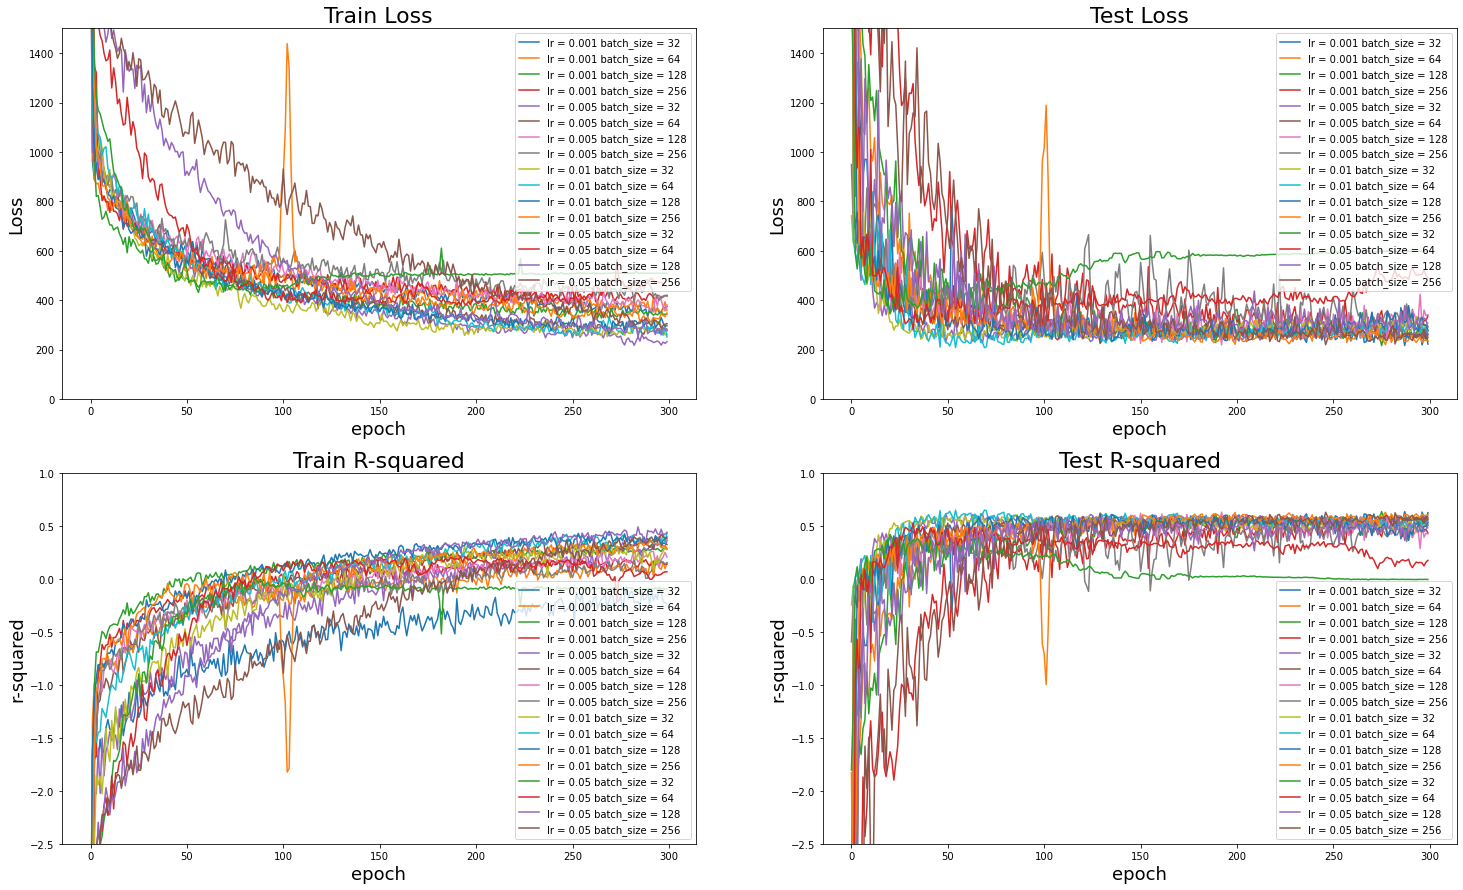

<Figure size 1800x1080 with 0 Axes>

In [14]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1500])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1500])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-2.5,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-2.5,1])

plt.show()

In [16]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

-0.23418015107655554
0.1508500657712215
0.28588405060539
0.1407684969045578
0.36329891475151477
0.32630513922280785
0.2069733002703837
0.1556116707263276
0.279044541289563
0.441482666139642
0.39703816403155473
0.2862556820118724
-0.0912731564659214
0.06905317048256744
0.4360986934204513
0.38052225803481166
___________________

0.6267966150660134
0.5721540631569516
0.5374701849906477
0.43518012802020556
0.5618367931846531
0.5830478145351237
0.42640481827059684
0.5087115620833865
0.48343382971363036
0.5387362890573688
0.5297237461155224
0.6045393799196854
-0.004112377367114561
0.1767292928975739
0.5103801519704969
0.558651611297337
___________________

374.1205071918035
357.766775004069
344.5520284016927
419.63677978515625
232.40742428019897
282.2115178426107
380.8699076334635
415.6836967468262
262.3007163354906
251.59552815755208
296.95473429361977
348.2628231048584
509.0870626417257
457.4262440999349
276.26801147460935
305.1098175048828
___________________

222.3408660888672
254.894866

### 2 best models

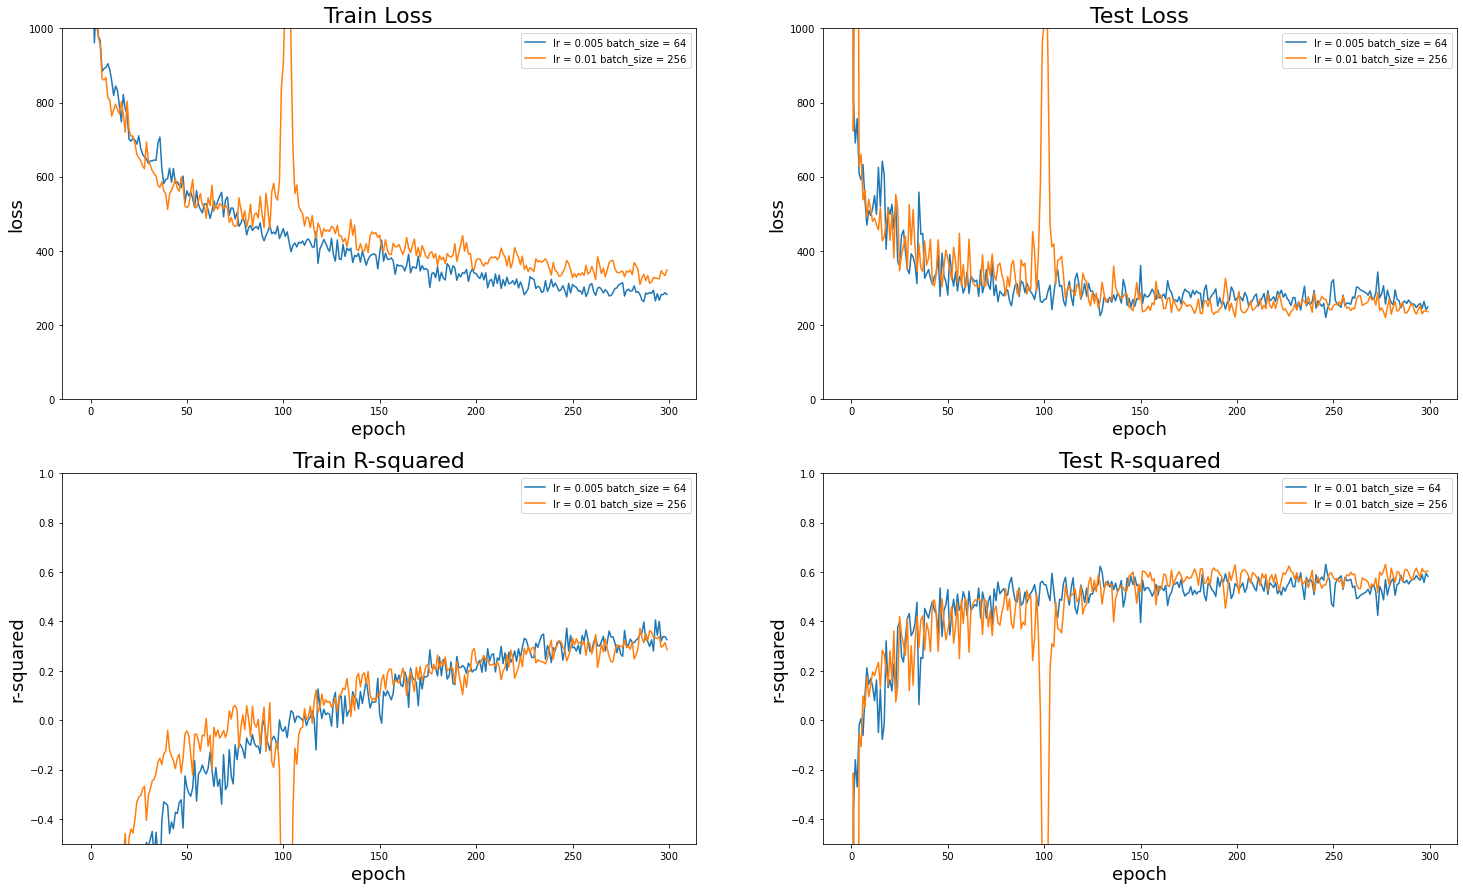

<Figure size 432x288 with 0 Axes>

In [18]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[5],label="lr = 0.005 batch_size = 64")
ax1.plot(train_losses_all[11],label="lr = 0.01 batch_size = 256")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1000])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[5],label="lr = 0.005 batch_size = 64")
ax2.plot(test_losses_all[11],label="lr = 0.01 batch_size = 256")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1000])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[5],label="lr = 0.005 batch_size = 64")
ax3.plot(train_accs_all[11],label="lr = 0.01 batch_size = 256")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.5,1])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[5],label="lr = 0.01 batch_size = 64")
ax4.plot(test_accs_all[11],label="lr = 0.01 batch_size = 256")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.5,1])
plt.show()

## 4.2. Training

In [19]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=533, shuffle=False)

In [20]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.01)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1000
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/protein_maccs_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 3472.136244032118, Accuracy: -5.894333385876426
Test Avg. loss: 6173.47265625, Accuracy: -12.377492330997024
################## EPOCH 2 ##################
Train Avg. loss: 1777.4858940972222, Accuracy: -2.4223015708387448
Test Avg. loss: 3220.296875, Accuracy: -5.978162620347209
################## EPOCH 3 ##################
Train Avg. loss: 1265.9331732855903, Accuracy: -1.503331625748417
Test Avg. loss: 951.4114990234375, Accuracy: -1.0616432912486333
################## EPOCH 4 ##################
Train Avg. loss: 1136.132086859809, Accuracy: -1.2053456869399755
Test Avg. loss: 1616.7528076171875, Accuracy: -2.503392542700876
################## EPOCH 5 ##################
Train Avg. loss: 969.2909206814236, Accuracy: -0.8741373523009304
Test Avg. loss: 798.13037109375, Accuracy: -0.7294938295278701
################## EPOCH 6 ##################
Train Avg. loss: 945.9804958767361, Accuracy: -0.8427806352238041
Test Avg. loss: 

Train Avg. loss: 599.9468926323784, Accuracy: -0.1789107259847067
Test Avg. loss: 286.8144836425781, Accuracy: 0.37849272504621345
################## EPOCH 50 ##################
Train Avg. loss: 584.8166842990452, Accuracy: -0.13469836143118633
Test Avg. loss: 323.4535827636719, Accuracy: 0.2990982158435437
################## EPOCH 51 ##################
Train Avg. loss: 563.8951416015625, Accuracy: -0.09732028431305341
Test Avg. loss: 322.61181640625, Accuracy: 0.3009223462311327
################## EPOCH 52 ##################
Train Avg. loss: 554.2549404568142, Accuracy: -0.08657362298678795
Test Avg. loss: 380.2104187011719, Accuracy: 0.17611005537461244
################## EPOCH 53 ##################
Train Avg. loss: 579.9306030273438, Accuracy: -0.13396885827355687
Test Avg. loss: 300.0010070800781, Accuracy: 0.3499184597915409
################## EPOCH 54 ##################
Train Avg. loss: 565.9204508463541, Accuracy: -0.10136046810651977
Test Avg. loss: 398.9154357910156, Accuracy:

Train Avg. loss: 524.3448282877604, Accuracy: -0.01647885737229994
Test Avg. loss: 302.3060607910156, Accuracy: 0.34492351553201483
################## EPOCH 98 ##################
Train Avg. loss: 501.84866672092016, Accuracy: 0.019952840355662263
Test Avg. loss: 305.04541015625, Accuracy: 0.3389875412673945
################## EPOCH 99 ##################
Train Avg. loss: 479.3123948838976, Accuracy: 0.06216664691982045
Test Avg. loss: 266.6719665527344, Accuracy: 0.422140171845131
################## EPOCH 100 ##################
Train Avg. loss: 508.4429185655382, Accuracy: 0.006462767242702573
Test Avg. loss: 266.38348388671875, Accuracy: 0.4227652593398712
################## EPOCH 101 ##################
Train Avg. loss: 539.0973951551649, Accuracy: -0.05042420936435426
Test Avg. loss: 355.8452453613281, Accuracy: 0.22890776681732616
################## EPOCH 102 ##################
Train Avg. loss: 560.4077521430122, Accuracy: -0.09365839730151765
Test Avg. loss: 279.88616943359375, Accu

Train Avg. loss: 501.96504380967883, Accuracy: 0.01644199193095708
Test Avg. loss: 257.8065185546875, Accuracy: 0.44135096182550226
################## EPOCH 146 ##################
Train Avg. loss: 489.1046719021267, Accuracy: 0.055946083326584364
Test Avg. loss: 286.18646240234375, Accuracy: 0.379853555546087
################## EPOCH 147 ##################
Train Avg. loss: 497.43201700846356, Accuracy: 0.029266343116803636
Test Avg. loss: 268.69683837890625, Accuracy: 0.41775236340836774
################## EPOCH 148 ##################
Train Avg. loss: 558.6441786024305, Accuracy: -0.09028477360185533
Test Avg. loss: 261.4626770019531, Accuracy: 0.4334282919551655
################## EPOCH 149 ##################
Train Avg. loss: 633.0867072211372, Accuracy: -0.24112799288073905
Test Avg. loss: 248.73191833496094, Accuracy: 0.4610150022285887
################## EPOCH 150 ##################
Train Avg. loss: 553.1668328179253, Accuracy: -0.09365769258998882
Test Avg. loss: 265.7947692871094

Train Avg. loss: 445.99146864149304, Accuracy: 0.12773435486262438
Test Avg. loss: 238.36131286621094, Accuracy: 0.4834873860362693
################## EPOCH 192 ##################
Train Avg. loss: 459.2703687879774, Accuracy: 0.10466036891831608
Test Avg. loss: 231.8478546142578, Accuracy: 0.4976016038641564
################## EPOCH 193 ##################
Train Avg. loss: 449.2234836154514, Accuracy: 0.11743882420606996
Test Avg. loss: 253.3011016845703, Accuracy: 0.45111390514995475
################## EPOCH 194 ##################
Train Avg. loss: 445.9987386067708, Accuracy: 0.13597049497434488
Test Avg. loss: 245.2482147216797, Accuracy: 0.4685639371650825
################## EPOCH 195 ##################
Train Avg. loss: 428.3967997233073, Accuracy: 0.16460914879055247
Test Avg. loss: 232.5756072998047, Accuracy: 0.49602461017628086
################## EPOCH 196 ##################
Train Avg. loss: 416.12730916341144, Accuracy: 0.19296083539682318
Test Avg. loss: 239.40823364257812, Acc

Train Avg. loss: 449.2112392849392, Accuracy: 0.12892436407602761
Test Avg. loss: 218.89370727539062, Accuracy: 0.5256723739890476
################## EPOCH 240 ##################
Train Avg. loss: 430.7049323187934, Accuracy: 0.15767976953588278
Test Avg. loss: 224.7575225830078, Accuracy: 0.5129658374106655
################## EPOCH 241 ##################
Train Avg. loss: 427.9752434624566, Accuracy: 0.175319788376883
Test Avg. loss: 232.92153930664062, Accuracy: 0.49527500316006867
################## EPOCH 242 ##################
Train Avg. loss: 480.5374688042535, Accuracy: 0.05788166701094763
Test Avg. loss: 222.75633239746094, Accuracy: 0.5173023103132879
################## EPOCH 243 ##################
Train Avg. loss: 422.88330078125, Accuracy: 0.16768871327175658
Test Avg. loss: 229.97479248046875, Accuracy: 0.5016604196004641
################## EPOCH 244 ##################
Train Avg. loss: 389.6965569390191, Accuracy: 0.23696162065700832
Test Avg. loss: 226.53131103515625, Accurac

Train Avg. loss: 381.7768385145399, Accuracy: 0.2558888595617483
Test Avg. loss: 222.6371307373047, Accuracy: 0.5175605556905151
################## EPOCH 287 ##################
Train Avg. loss: 386.7514478895399, Accuracy: 0.24346797854570518
Test Avg. loss: 248.8173065185547, Accuracy: 0.4608299619680225
################## EPOCH 288 ##################
Train Avg. loss: 374.56374104817706, Accuracy: 0.26758227857066114
Test Avg. loss: 272.93170166015625, Accuracy: 0.40857572326752045
################## EPOCH 289 ##################
Train Avg. loss: 381.3061692979601, Accuracy: 0.2541623347313023
Test Avg. loss: 254.36233520507812, Accuracy: 0.4488142798746855
################## EPOCH 290 ##################
Train Avg. loss: 379.6575741238064, Accuracy: 0.2547619004876879
Test Avg. loss: 244.08352661132812, Accuracy: 0.4710877573313351
################## EPOCH 291 ##################
Train Avg. loss: 381.4795498318142, Accuracy: 0.2606930169163314
Test Avg. loss: 248.1955108642578, Accuracy

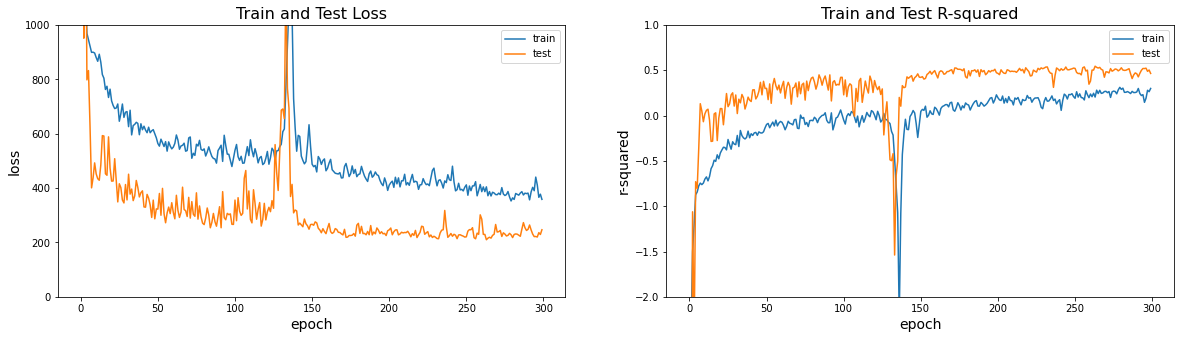

<Figure size 1440x360 with 0 Axes>

In [22]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.set_ylim([0,1000])
ax1.legend()

ax2.set_title("Train and Test R-squared", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("r-squared", fontsize=14)
ax2.set_ylim([-2,1])
ax2.legend()
plt.show()

In [23]:
model = FCNN()
model.load_state_dict(torch.load('../../models/protein_maccs_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 9.425876
MSE: 209.86612
RMSE: 14.486756
R2 Square 0.5452345014264861 

